In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [ ]:
df=pd.read_csv('https://drive.google.com/uc?export=download&id=1QXnpsolrfLIkOlwSNYUgWz1j-Q4omiSO')

In [ ]:
col = ['_HCVU652', '_TOTINDA', '_EXTETH3', '_ALTETH3', '_DENVST3', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1', '_DRDXAR2',
       '_PRACE2', '_MRACE2', '_HISPANC', '_RACE1', '_RACEG22', '_RACEGR4', '_RACEPR1', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80',
       '_AGE_G', 'HTIN4', 'HTM4', 'WTKG3', '_BMI5', '_BMI5CAT', '_RFBMI5', '_CHLDCNT', '_EDUCAG', '_INCOMG1', '_RFMAM22',
       '_MAM5023', '_HADCOLN', '_CLNSCP1', '_HADSIGM', '_SGMSCP1', '_SGMS101', '_RFBLDS5', '_STOLDN1', '_VIRCOL1', '_SBONTI1',
       '_CRCREC2', '_SMOKER3', '_RFSMOK3', '_CURECI2', '_YRSSMOK', '_PACKDAY', '_PACKYRS', '_YRSQUIT', '_SMOKGRP', '_LCSREC',
       'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2', '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4', 'Class']

In [ ]:
df = df[col]

In [ ]:
df

,_HCVU652,_TOTINDA,_EXTETH3,_ALTETH3,_DENVST3,_MICHD,_LTASTH1,_CASTHM1,_ASTHMS1,_DRDXAR2,...,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,Class
0,9.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,2.0,...,NaN,1.0,3.000000e+00,1.0,2.300000e+01,1.0,1.0,9.0,2.0,Mild CD
1,2.0,1.0,2.0,NaN,2.0,2.0,1.0,1.0,3.0,1.0,...,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0,No CD
2,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,...,NaN,1.0,3.000000e+00,1.0,2.300000e+01,1.0,1.0,1.0,2.0,Mild CD
3,9.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,...,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,No CD
4,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,...,NaN,1.0,3.000000e+00,1.0,4.700000e+01,1.0,1.0,1.0,1.0,No CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63625,9.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,...,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,No CD
63626,1.0,2.0,2.0,NaN,1.0,2.0,1.0,1.0,3.0,1.0,...,NaN,1.0,7.000000e+00,1.0,9.300000e+01,1.0,NaN,NaN,2.0,No CD
63627,9.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,2.0,...,NaN,1.0,1.400000e+01,1.0,1.000000e+02,1.0,1.0,1.0,2.0,No CD
63628,1.0,1.0,1.0,NaN,1.0,2.0,1.0,1.0,3.0,2.0,...,NaN,1.0,5.000000e+01,1.0,3.500000e+02,1.0,NaN,NaN,2.0,Mild CD


In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2, pvalue, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
#@title Function for categorical variable exploration
# mapping = {1:'Always', 2:"Usually",..., 7:"Not Sure", 9:"Refused"}
def explore_cat(df, feature, mapping, include_refused=False):
  subdf = df[[feature, 'Class']]
  subdf[feature] = subdf[feature].replace(mapping)
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(subdf[feature]=="Not Sure")} not sure values, {np.sum(subdf[feature]=="Refused")} refused values')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset = [feature], inplace=True)
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    if not include_refused:
      subdf = subdf[~((subdf[feature] == 'Not Sure') | (subdf[feature] == 'Refused'))]

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())[:-2]
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

## Test

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 36165 refused values


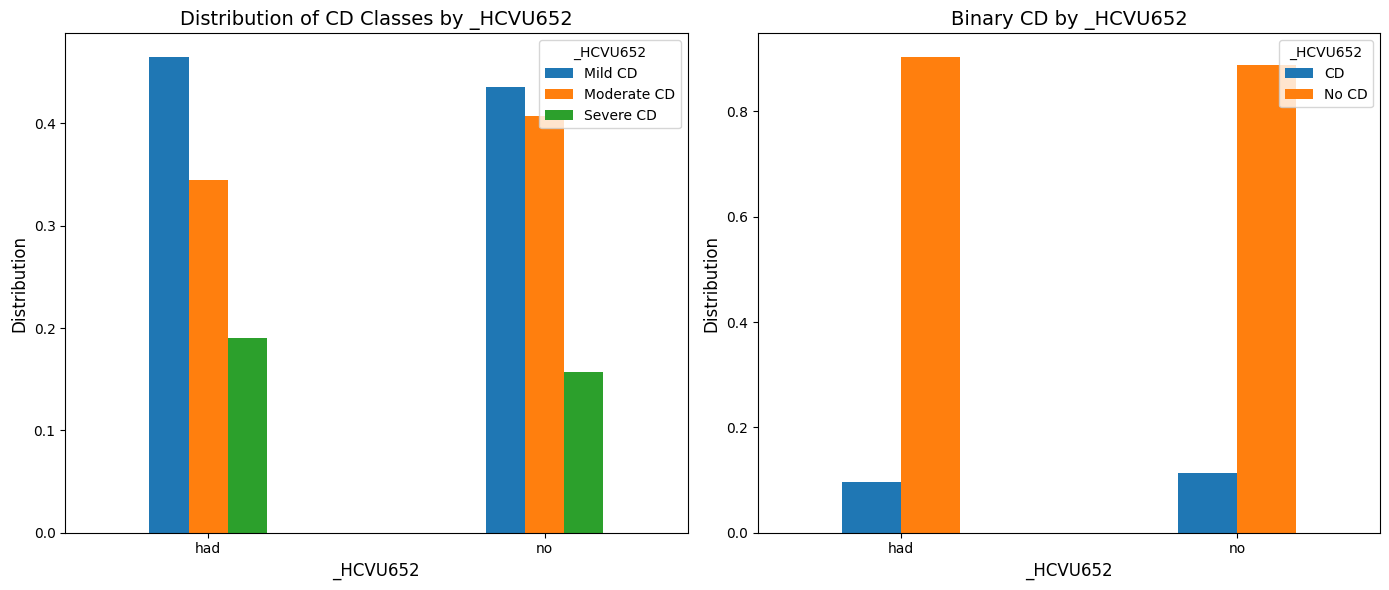

Cramers V for multi-class classification is: 0.019754328730909307
Cramers V for binary classification is: 0.01021700423268222


In [ ]:
# mapping = {1:"Gay", 2: "Straight", 3: "Bi", 4:"Others", 7: "Not Sure", 9: "Refused"}
# mapping = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native Hawaiian', 6: 'American Indian', 7: 'Mixed', 8:'Others',
#             77: "Not Sure", 99: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
mapping = {1: "had", 2: "no", 7: "Not Sure", 9: "Refused"}
feature = '_HCVU652'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 185 refused values


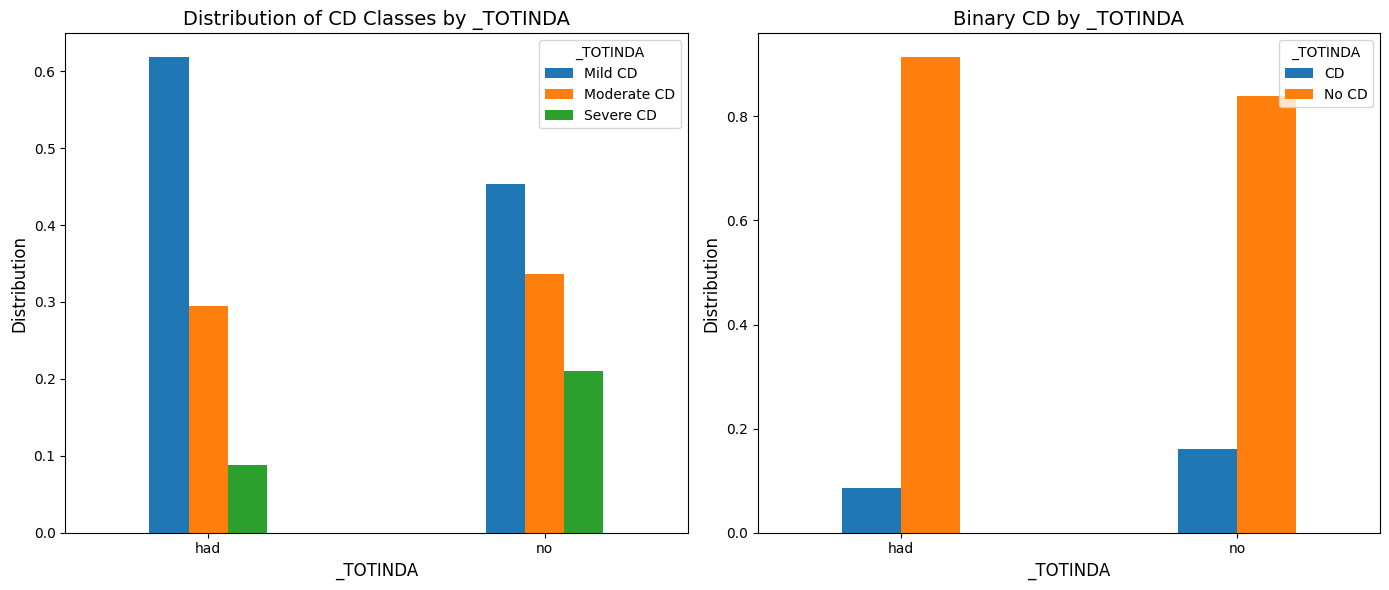

Cramers V for multi-class classification is: 0.197714399911517
Cramers V for binary classification is: 0.10456950090555286


In [ ]:
mapping = {1: "had", 2: "no", 7: "Not Sure", 9: "Refused"}
feature = '_TOTINDA'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 1805 refused values


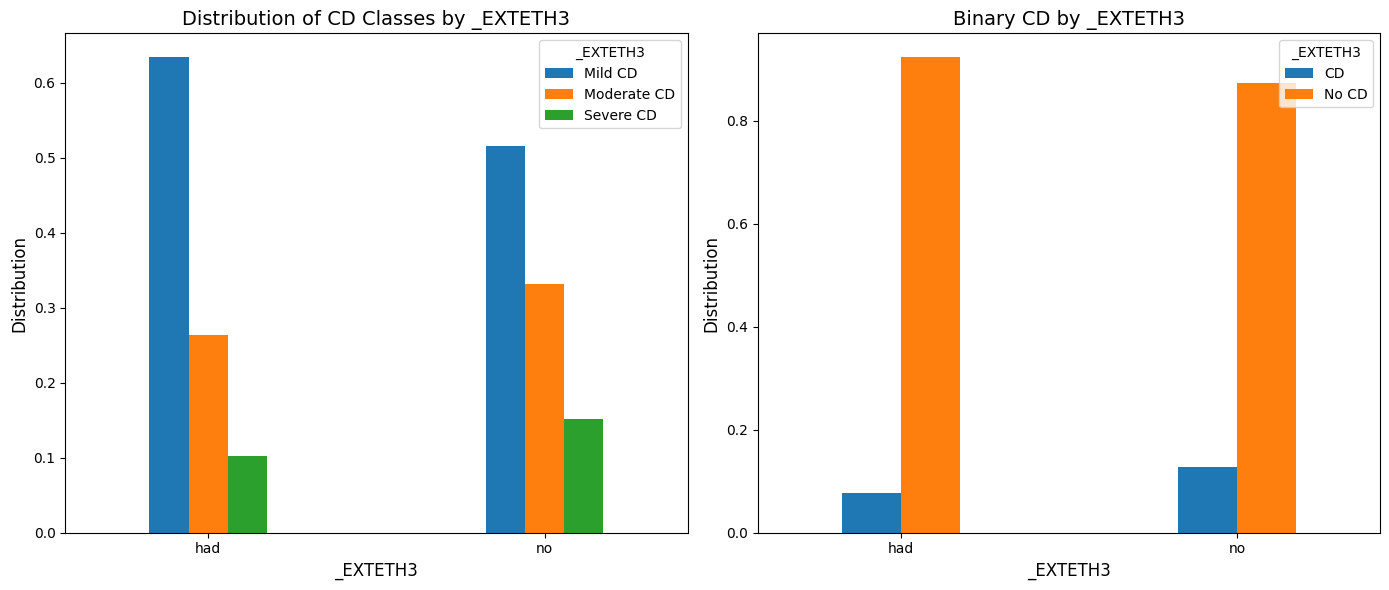

Cramers V for multi-class classification is: 0.11232553224528882
Cramers V for binary classification is: 0.0824104917187121


In [ ]:
mapping = {1: "had", 2: "no", 7: "Not Sure", 9: "Refused"}
feature = '_EXTETH3'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 28193 missing values, 0 not sure values, 2505 refused values


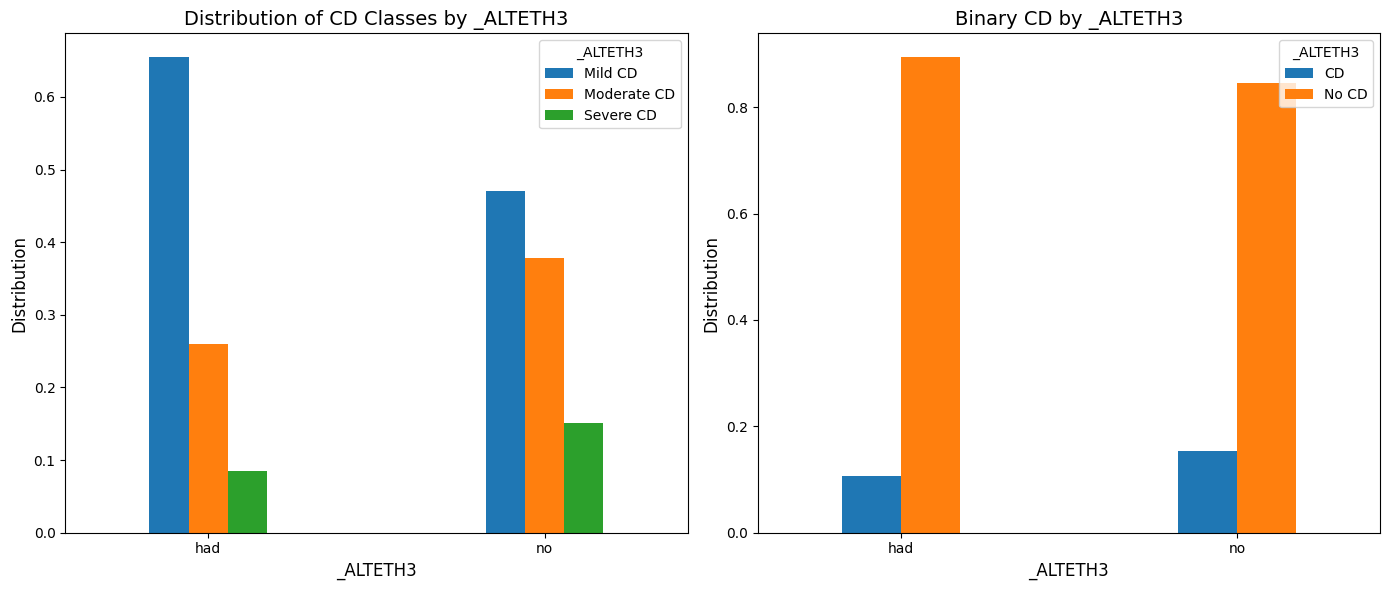

Cramers V for multi-class classification is: 0.13613194067841225
Cramers V for binary classification is: 0.047368113321955174


In [ ]:
mapping = {1: "had", 2: "no", 7: "Not Sure", 9: "Refused"}
feature = '_ALTETH3'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 757 refused values


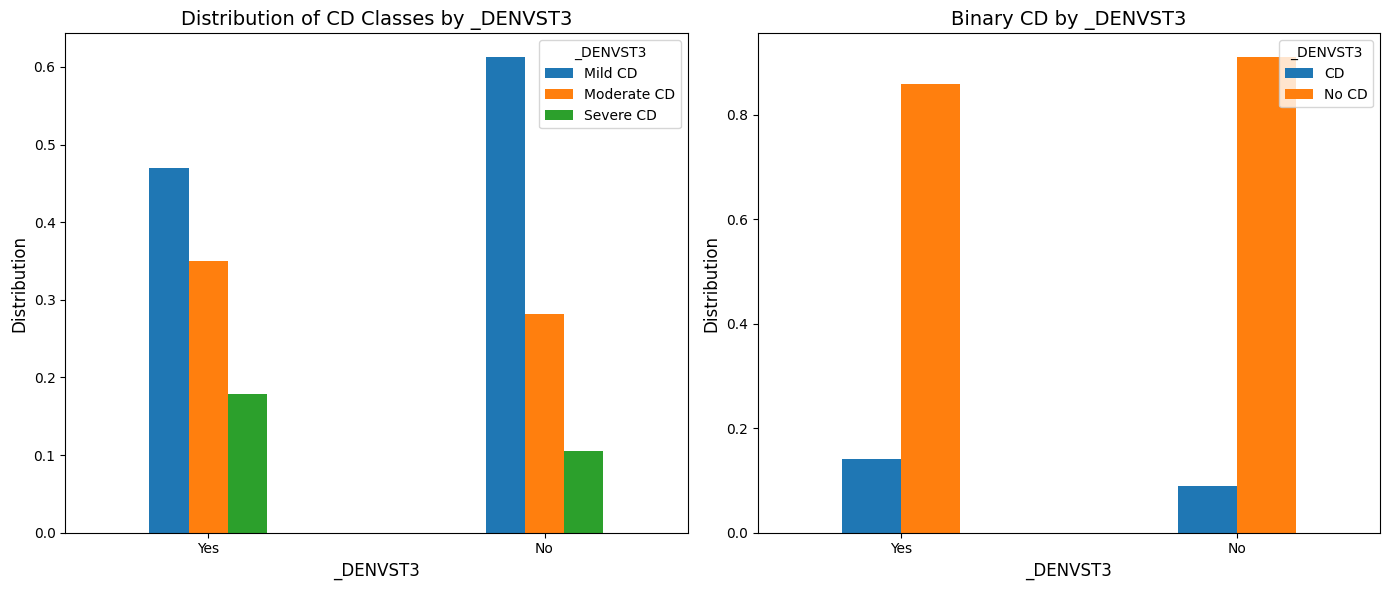

Cramers V for multi-class classification is: 0.14721742136657184
Cramers V for binary classification is: 0.07642025848333299


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_DENVST3'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 771 missing values, 0 not sure values, 0 refused values


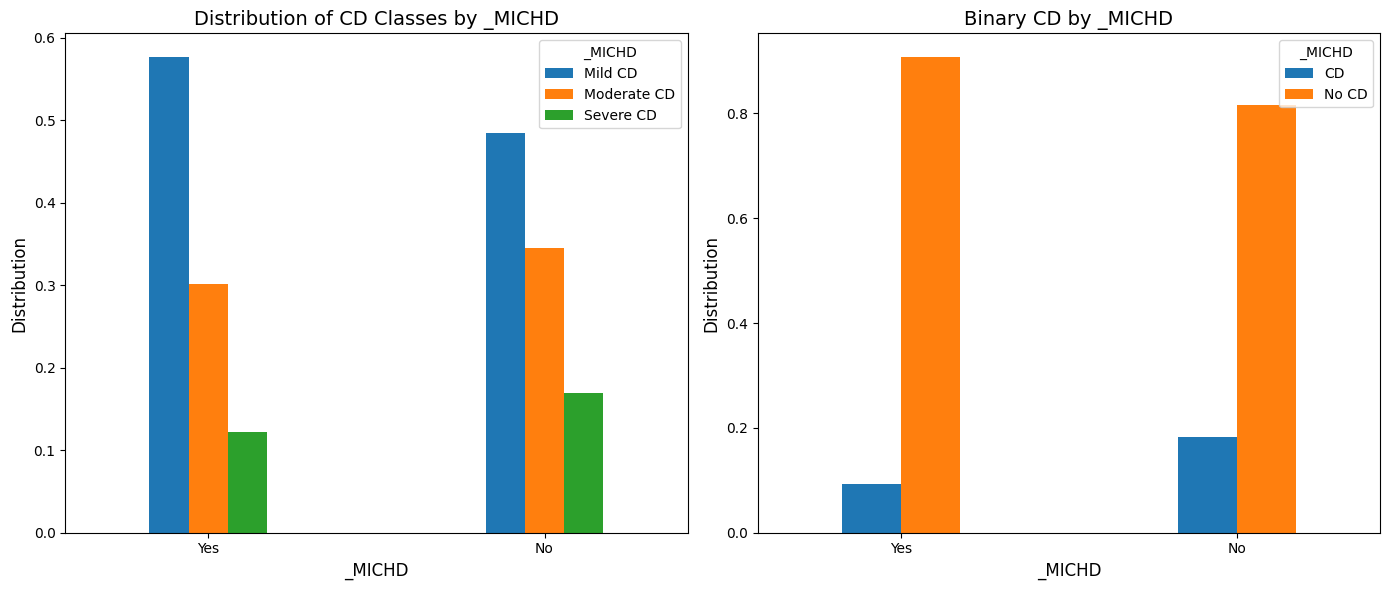

Cramers V for multi-class classification is: 0.07933388823477801
Cramers V for binary classification is: 0.09817361834586119


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_MICHD'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 239 refused values


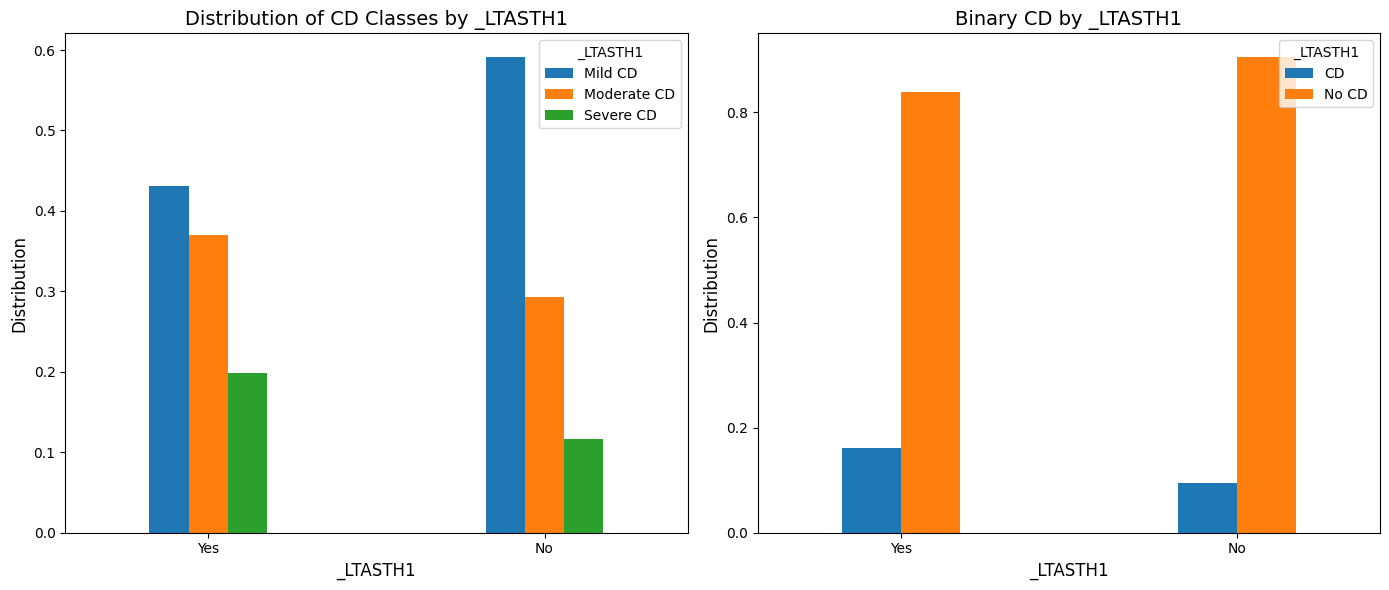

Cramers V for multi-class classification is: 0.14127350079311538
Cramers V for binary classification is: 0.07670316933952741


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_LTASTH1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 533 refused values


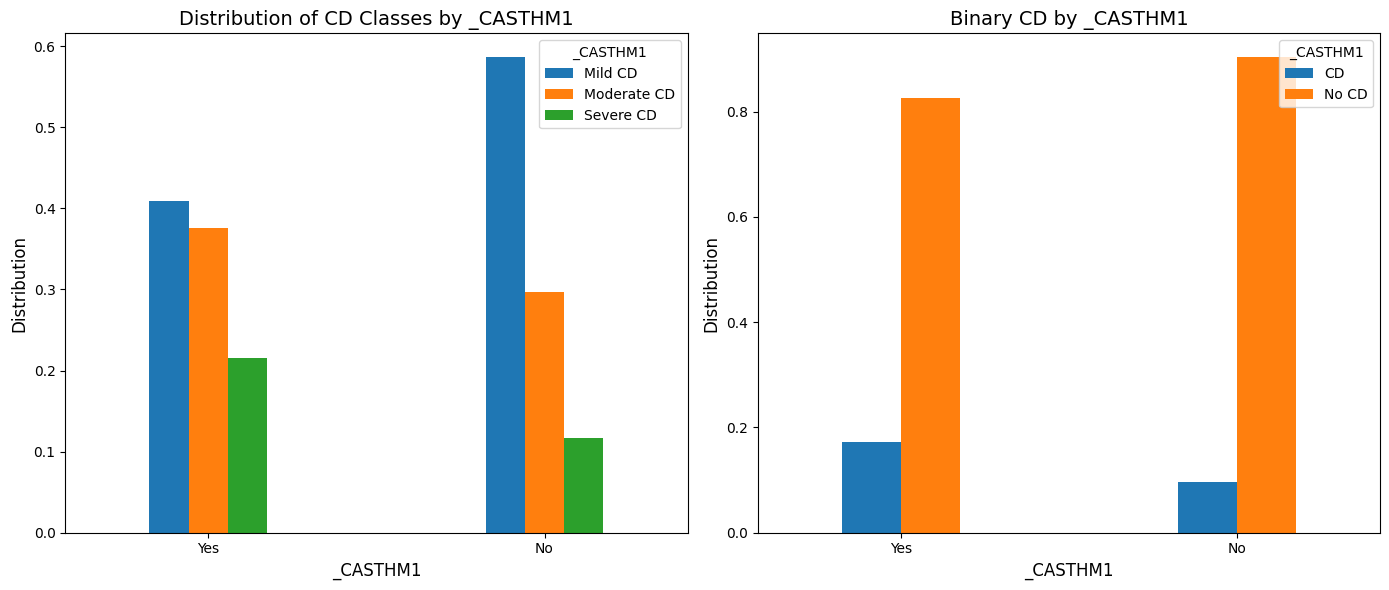

Cramers V for multi-class classification is: 0.14656740108632504
Cramers V for binary classification is: 0.07750235065445747


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_CASTHM1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 533 refused values


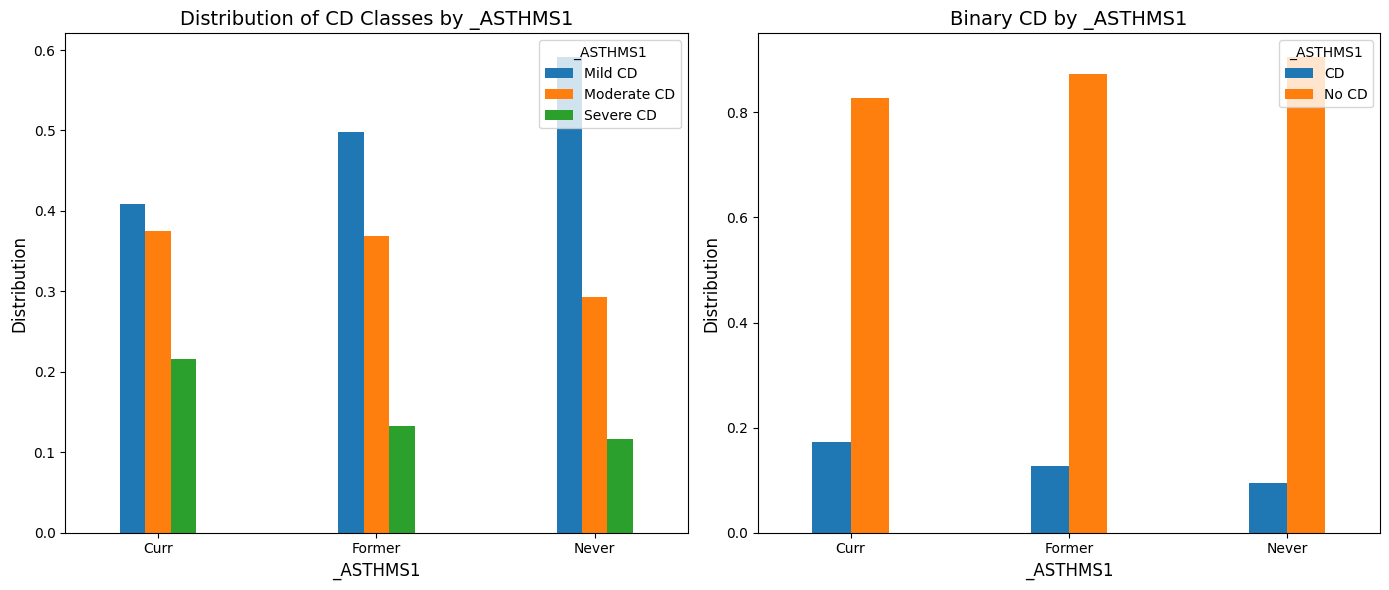

Cramers V for multi-class classification is: 0.10641541568742202
Cramers V for binary classification is: 0.07975313436630767


In [ ]:
mapping = {1: "Curr", 2: "Former", 3: "Never", 7: "Not Sure", 9: "Refused"}
feature = '_ASTHMS1'

explore_cat(df, feature, mapping, include_refused=False)


<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 337 missing values, 0 not sure values, 0 refused values


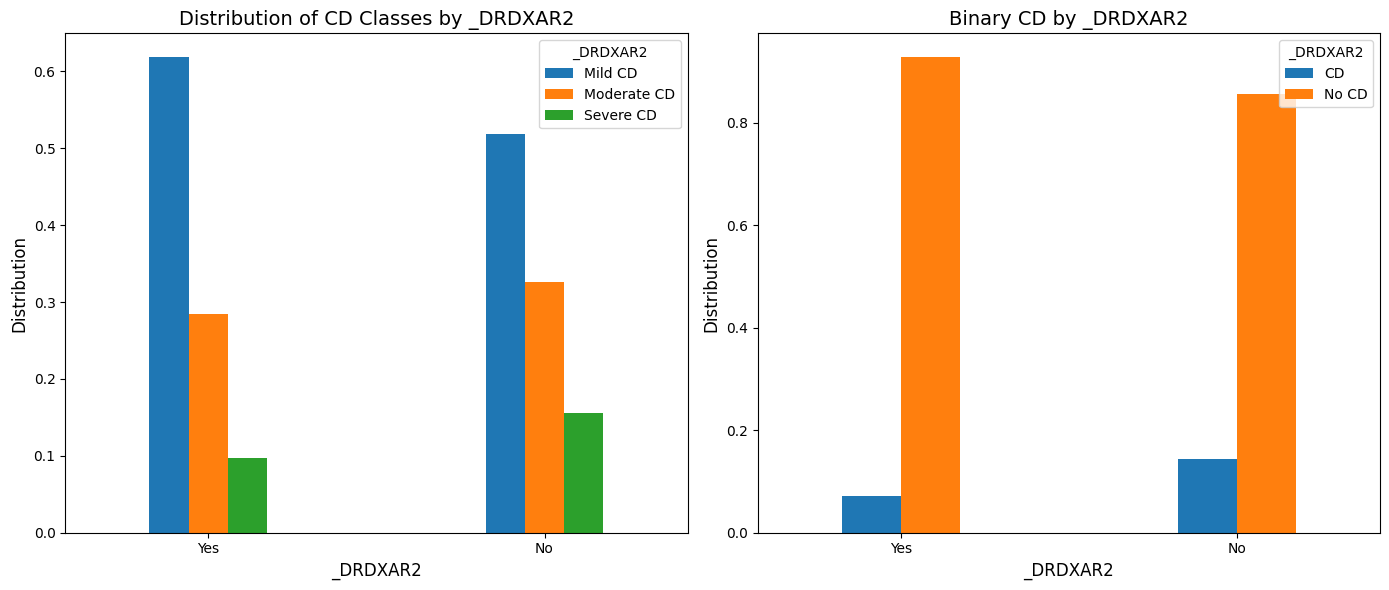

Cramers V for multi-class classification is: 0.10624250379197465
Cramers V for binary classification is: 0.11563420215119237


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_DRDXAR2'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 357 not sure values, 1178 refused values


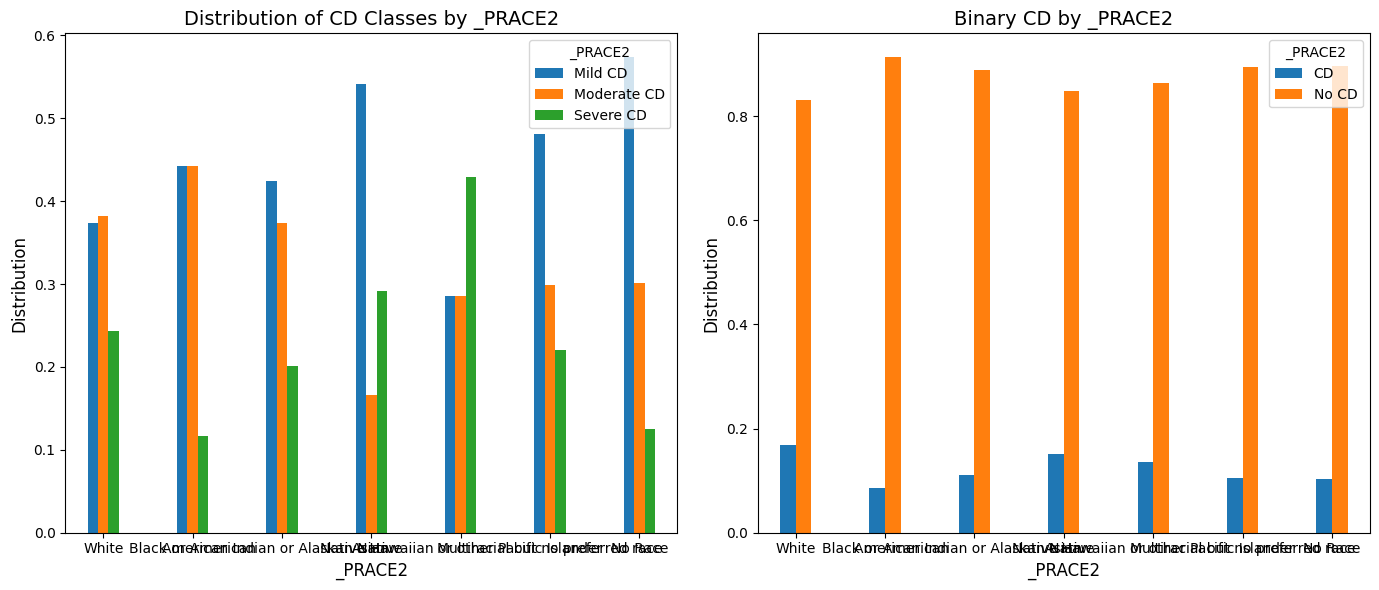

Cramers V for multi-class classification is: 0.07783042292772718
Cramers V for binary classification is: 0.023177088320300986


In [ ]:
mapping = {1: "White", 2: "Black or American", 3: "American Indian or Alaskan Native", 4: "Asian", 5: "Native Hawaiian or other Pacific Islander", 7: "Multiracial but no preferred race", 88: "No Race", 77: "Not Sure", 99: "Refused"}
feature = '_PRACE2'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 357 not sure values, 1178 refused values


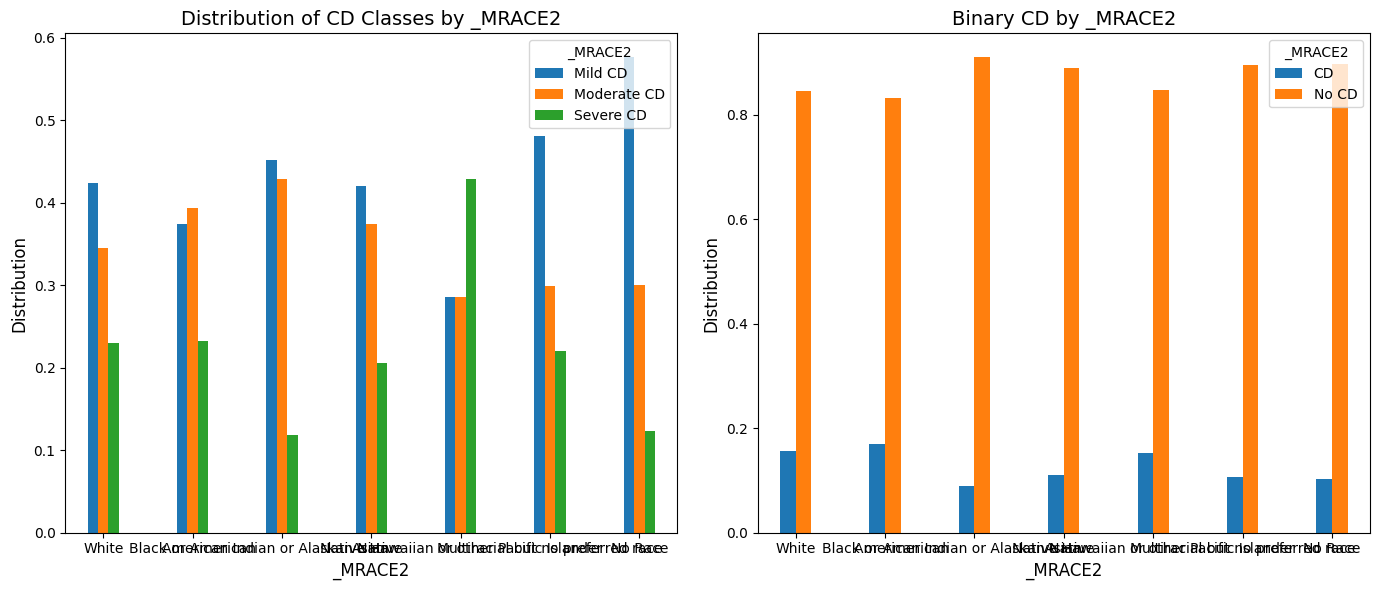

Cramers V for multi-class classification is: 0.08200898229320776
Cramers V for binary classification is: 0.028470471170719304


In [ ]:
mapping = {1: "White", 2: "Black or American", 3: "American Indian or Alaskan Native", 4: "Asian", 5: "Native Hawaiian or other Pacific Islander", 7: "Multiracial but no preferred race", 88: "No Race", 77: "Not Sure", 99: "Refused"}
feature = '_MRACE2'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 714 refused values


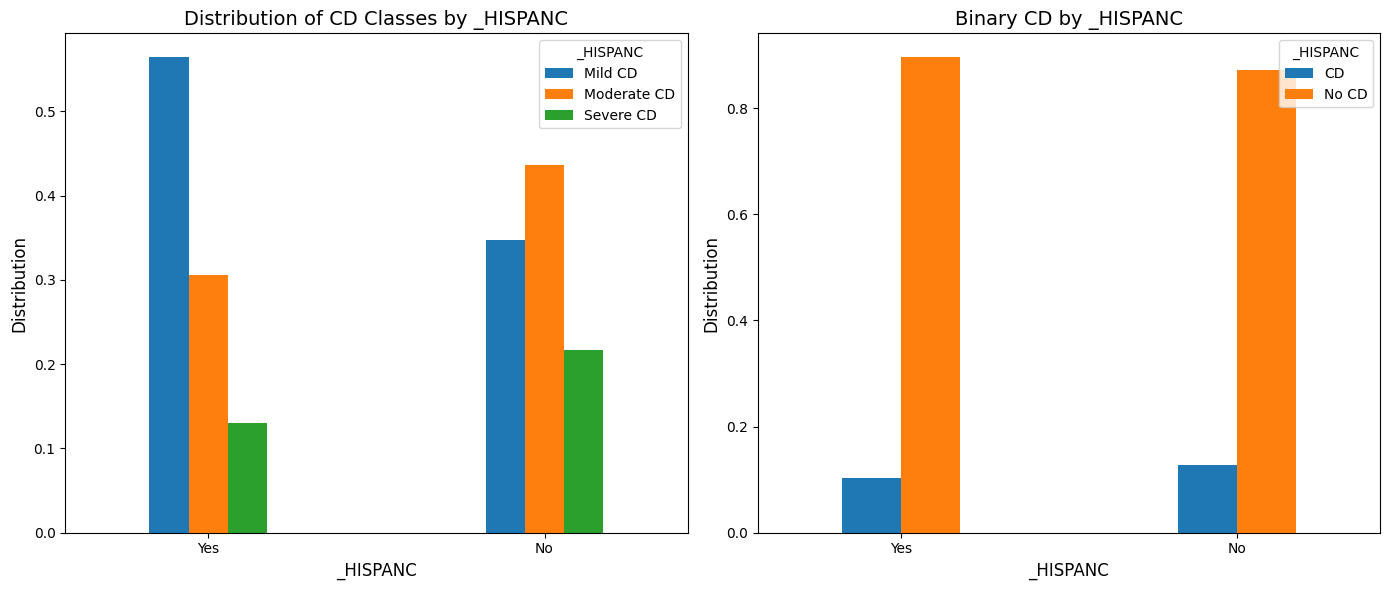

Cramers V for multi-class classification is: 0.08925012835462924
Cramers V for binary classification is: 0.013667274959708875


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_HISPANC'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 1877 refused values


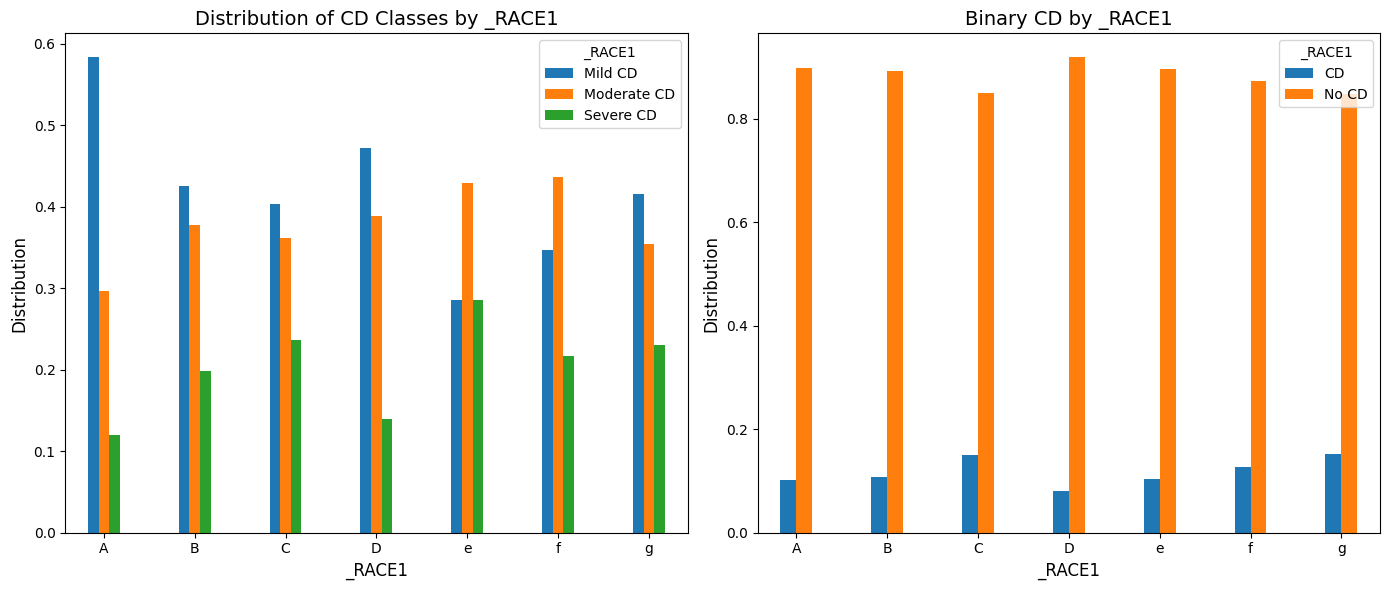

Cramers V for multi-class classification is: 0.09669415012040938
Cramers V for binary classification is: 0.02673634738622621


In [ ]:
mapping = {1:"A", 2:"B", 3: "C", 4: "D", 5: "e", 6: "f" ,7:"g", 8: "f", 9: "Refused"}
feature = '_RACE1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 1877 refused values


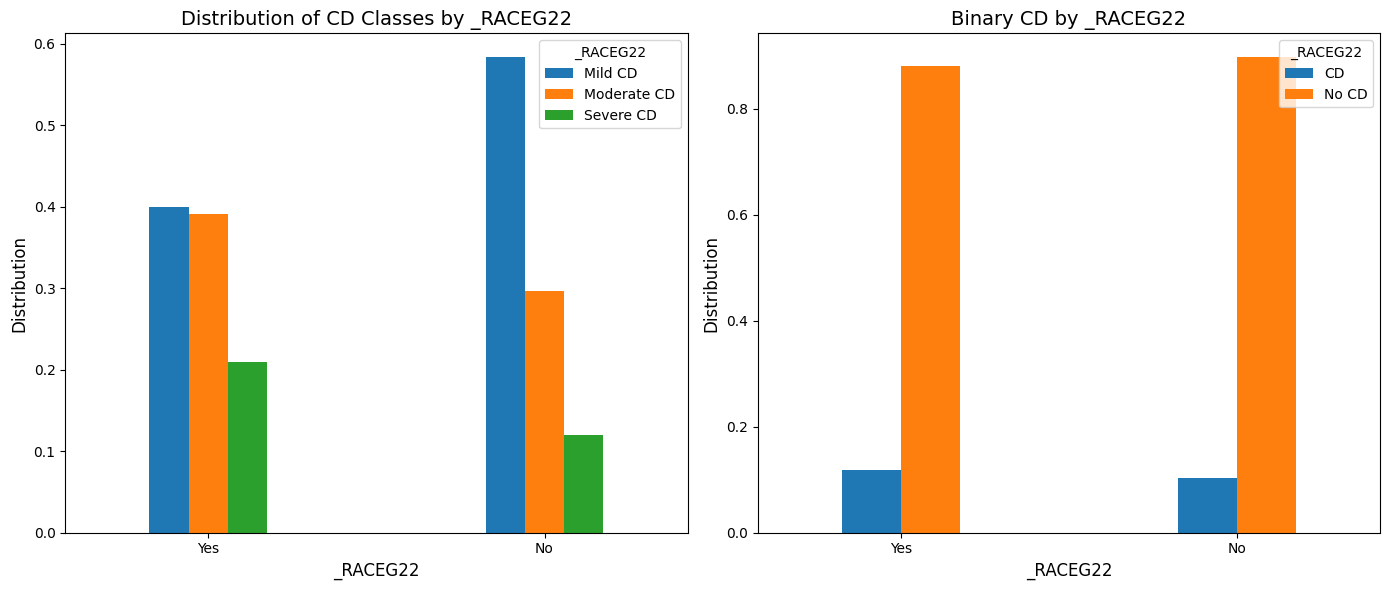

Cramers V for multi-class classification is: 0.13754834880912972
Cramers V for binary classification is: 0.017399364666406986


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_RACEG22'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 1877 refused values


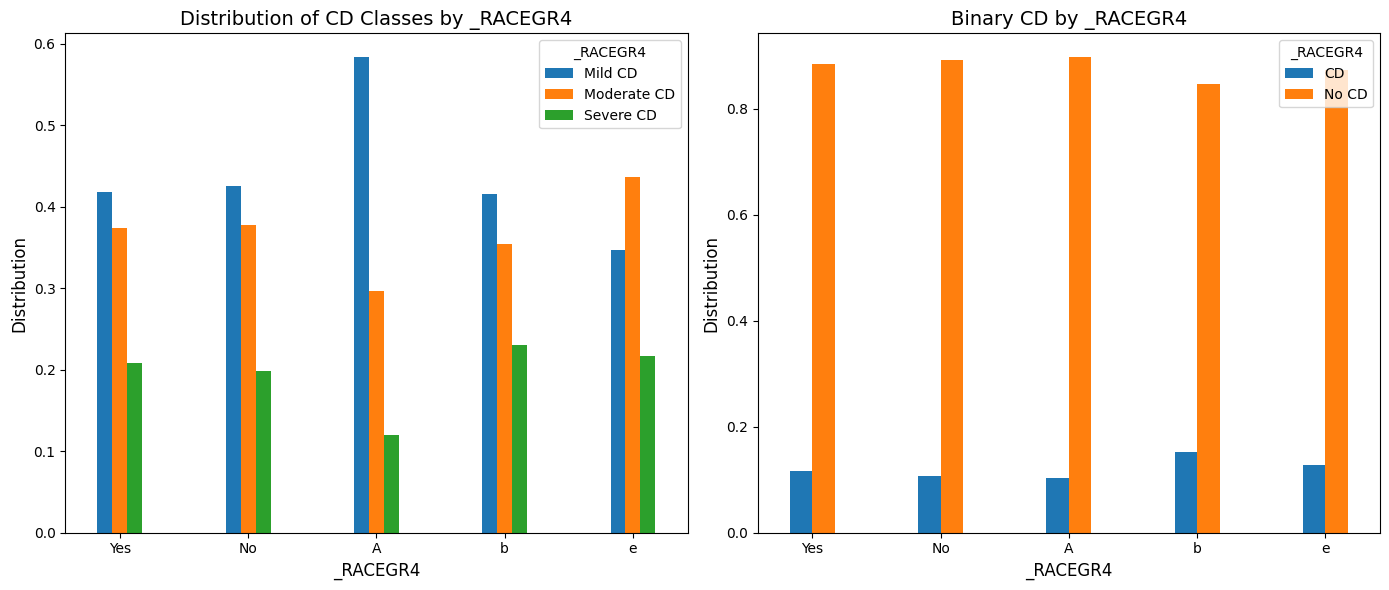

Cramers V for multi-class classification is: 0.09725031919643053
Cramers V for binary classification is: 0.02354328753970162


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "A", 4: "b", 5:"e" ,7: "f", 9: "Refused"}
feature = '_RACEGR4'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 2285 refused values


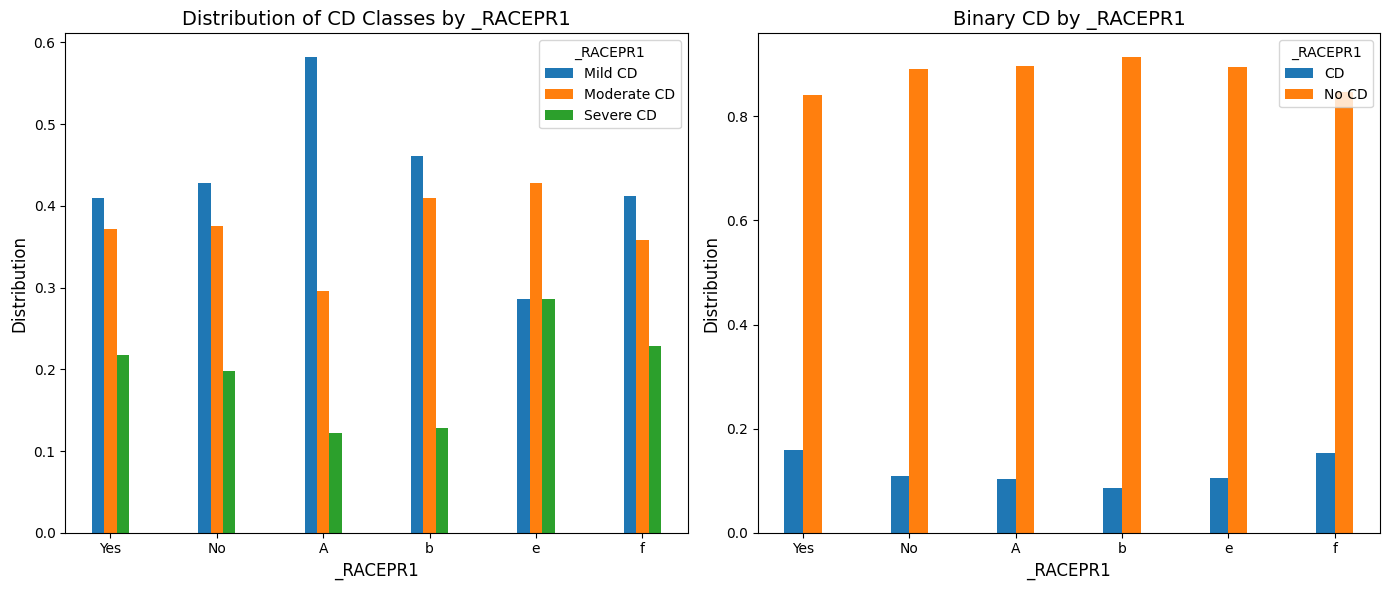

Cramers V for multi-class classification is: 0.07181117954091246
Cramers V for binary classification is: 0.02425391199992301


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "A", 4: "b", 5:"e" ,6: "f", 7: "Refused", 9: "AA"}
feature = '_RACEPR1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 0 refused values


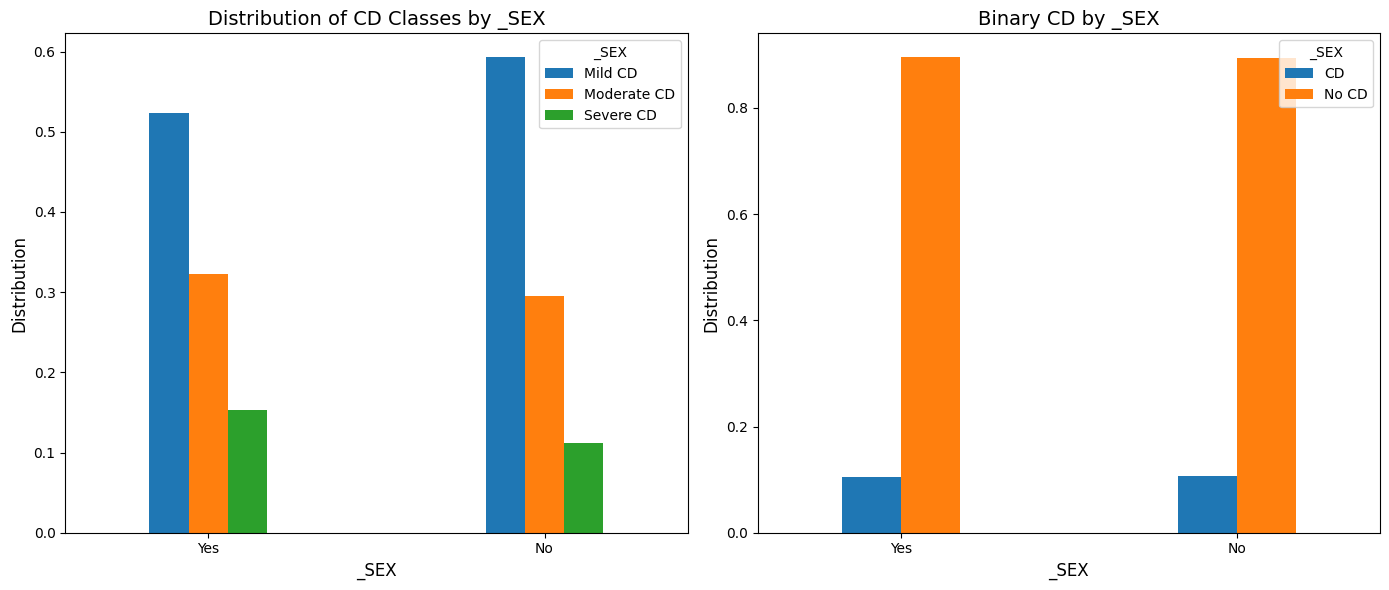

Cramers V for multi-class classification is: 0.07464146803413708
Cramers V for binary classification is: 0.0


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_SEX'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 0 refused values


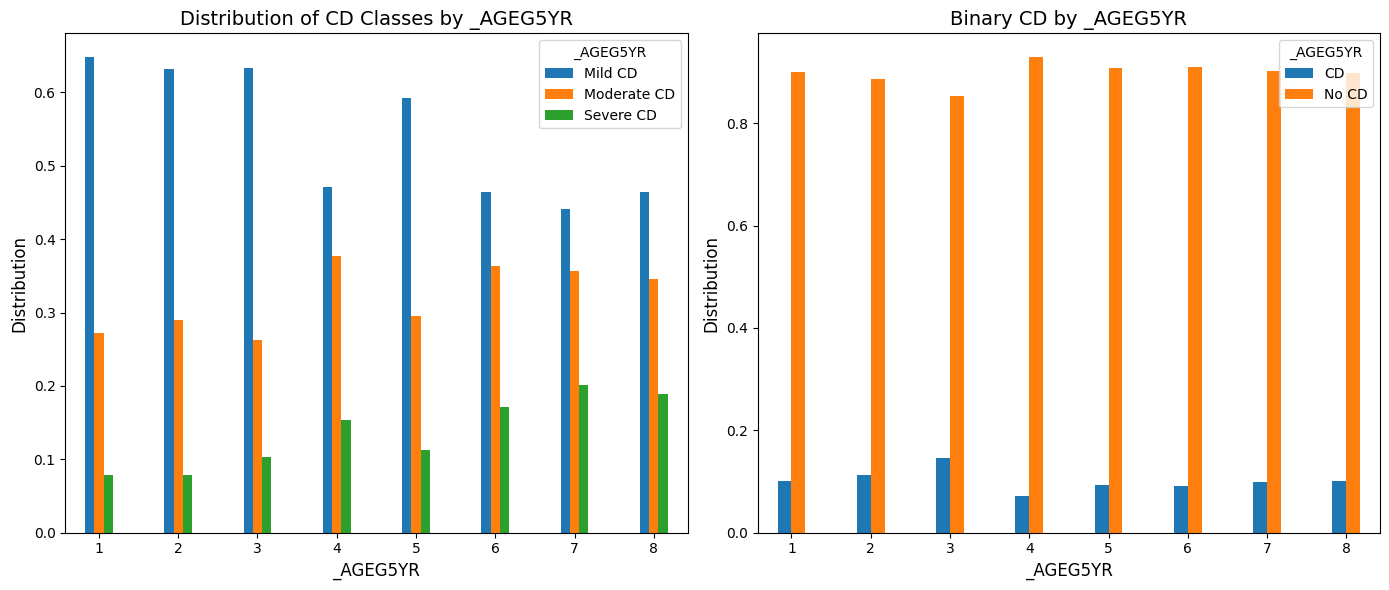

Cramers V for multi-class classification is: 0.12811677793806917
Cramers V for binary classification is: 0.0543304297432896


In [ ]:
mapping = {1: "1", 2: "2", 3: "3", 4: "4", 5:"5" ,6: "6", 7: "7", 8: "8", 9: "8", 10: "10"}
feature = '_AGEG5YR'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 0 refused values


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (6).

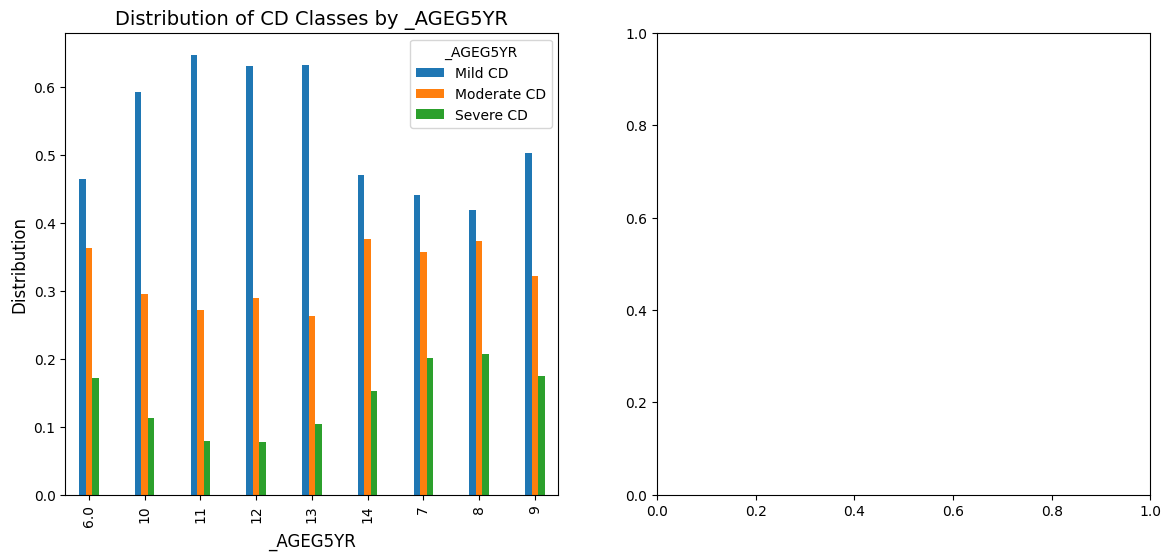

In [ ]:
mapping = {7: "7",8: "8", 9: "9", 10: "10", 11: "11", 12: "12", 13: "13", 14: "14"}
feature = '_AGEG5YR'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 1199 not sure values, 0 refused values


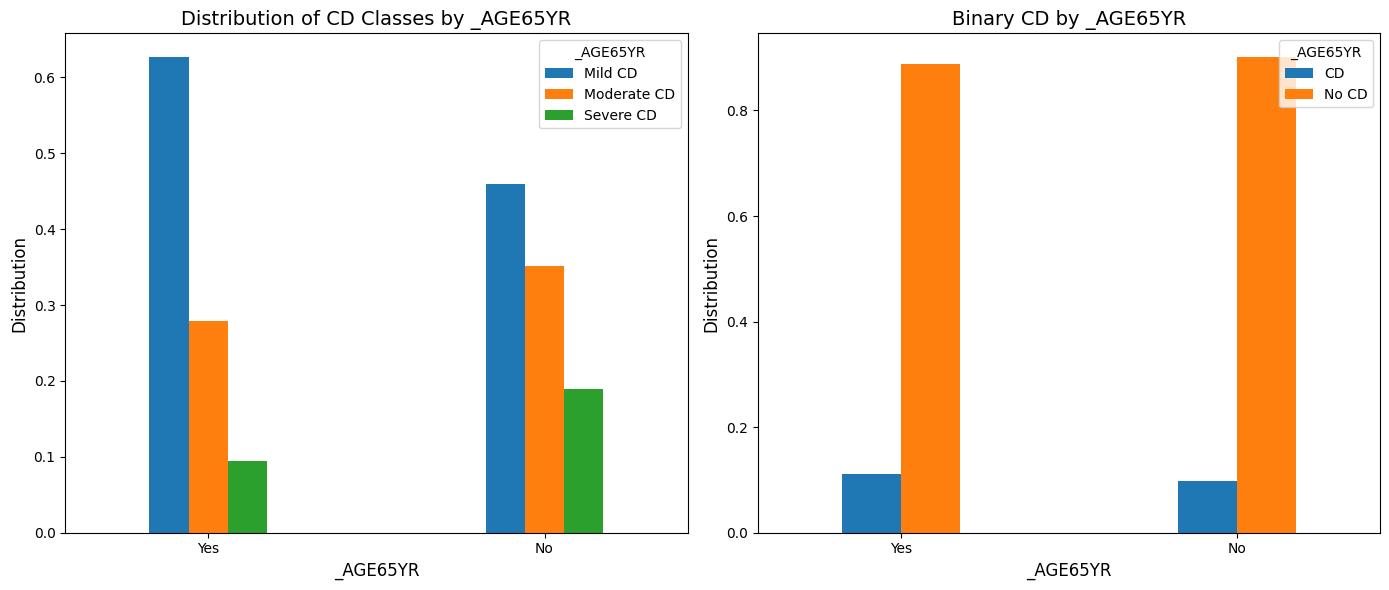

Cramers V for multi-class classification is: 0.18051529214435924
Cramers V for binary classification is: 0.019586395001829578


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "Not Sure", 9: "Refused"}
feature = '_AGE65YR'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 0 refused values


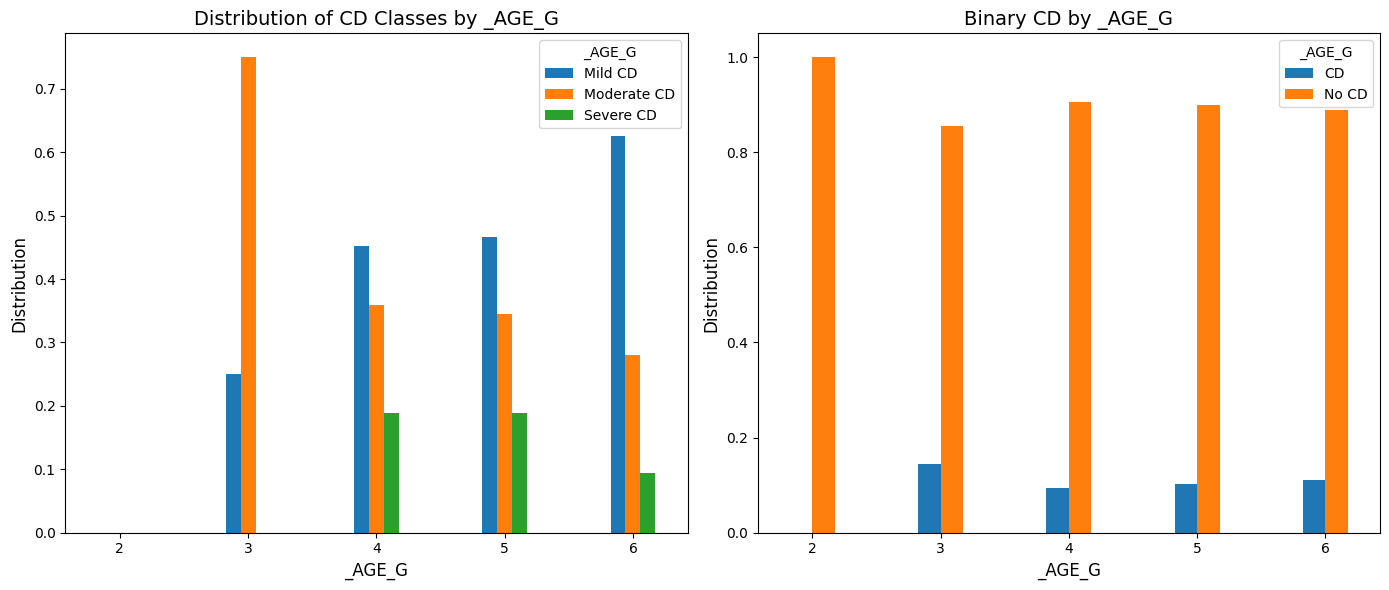

Cramers V for multi-class classification is: 0.1273318703133111
Cramers V for binary classification is: 0.02054360338684787


In [ ]:
mapping = {2: "2", 3: "3", 4: "4", 5:"5" ,6: "6", 9: "Refused", 1: "1"}
feature = '_AGE_G'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 4149 missing values, 0 not sure values, 0 refused values


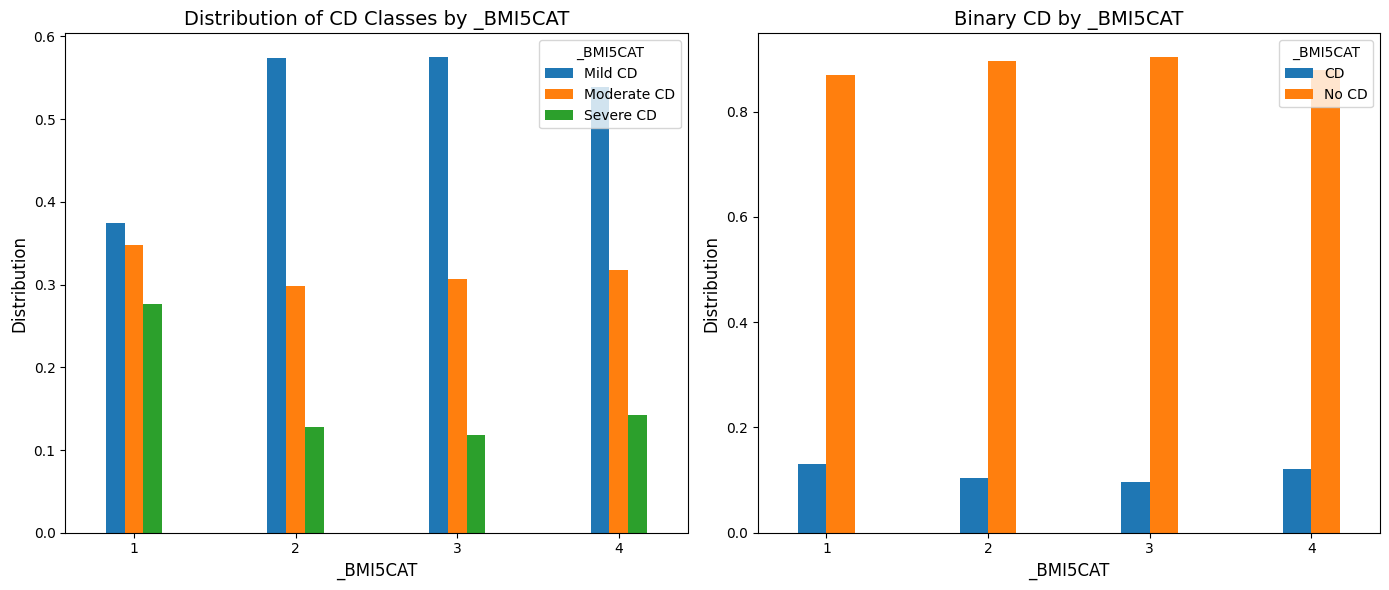

Cramers V for multi-class classification is: 0.04799515858824446
Cramers V for binary classification is: 0.03389631246233687


In [ ]:
mapping = {1: "1", 2: "2", 3: "3", 4: "4",7: "7", 9: "Refused"}
feature = '_BMI5CAT'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 4149 refused values


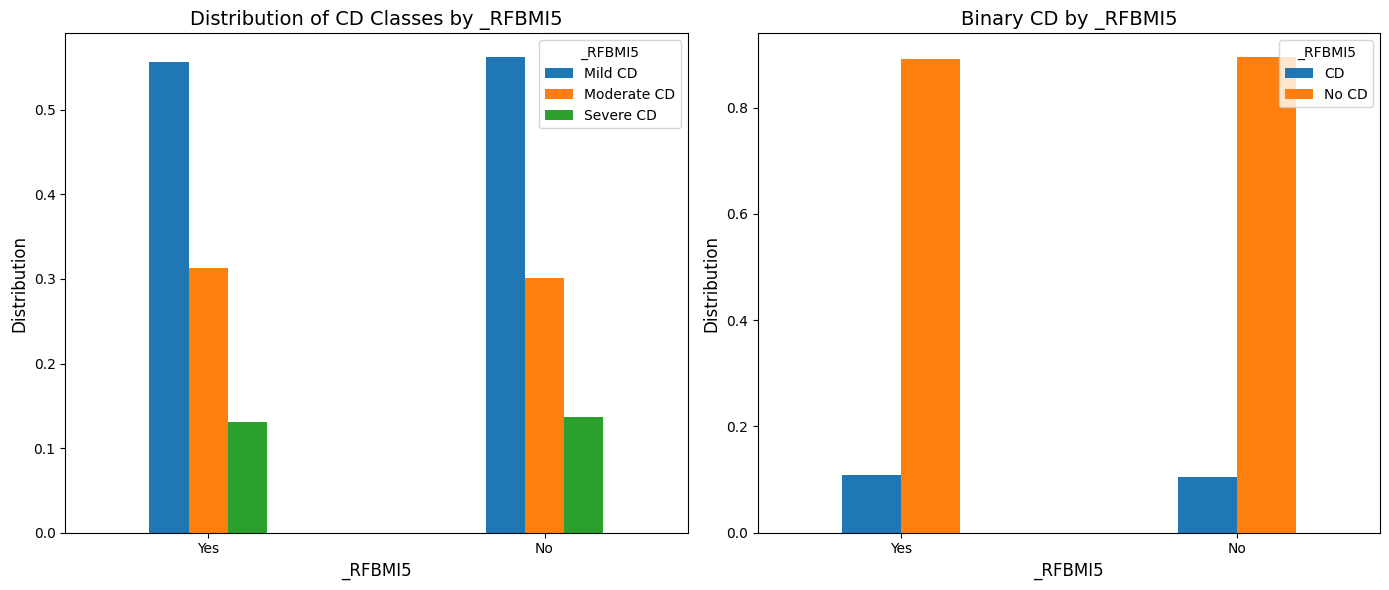

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.0021896403538168643


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_RFBMI5'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 493 refused values


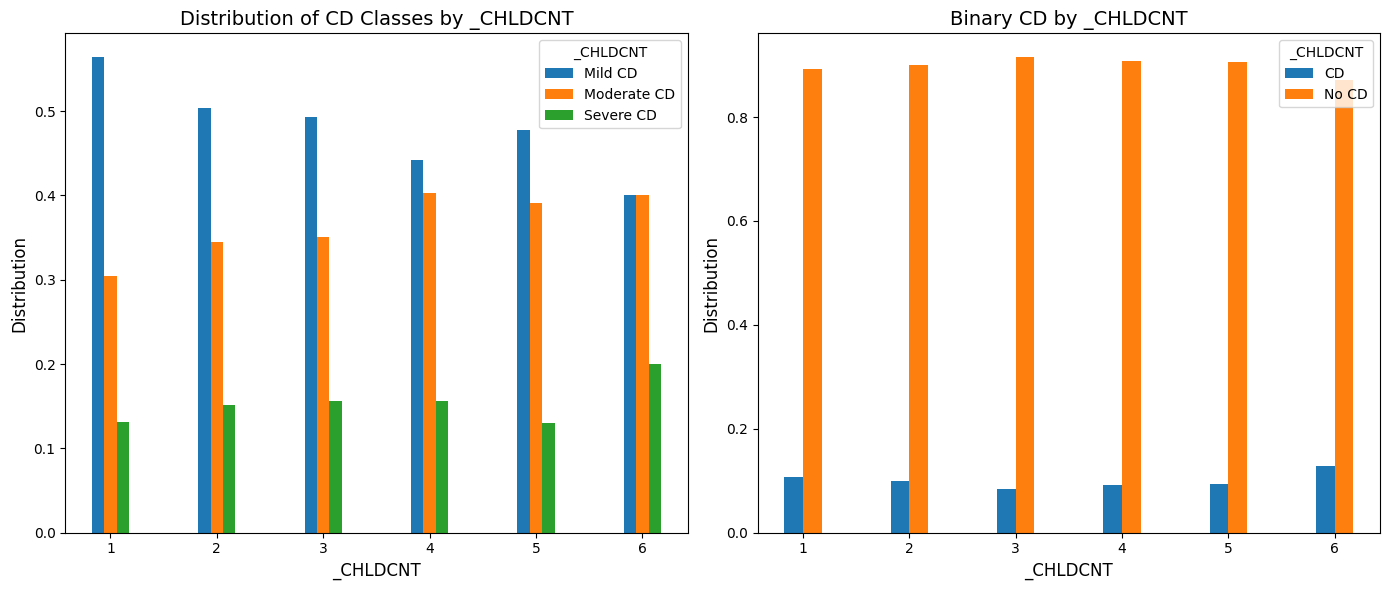

Cramers V for multi-class classification is: 0.023038009156535984
Cramers V for binary classification is: 0.014183833520304424


In [ ]:
mapping = {1: "1", 2: "2", 3: "3", 4: "4", 5:"5" ,6: "6", 7: "7",9: "Refused"}
feature = '_CHLDCNT'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 255 refused values


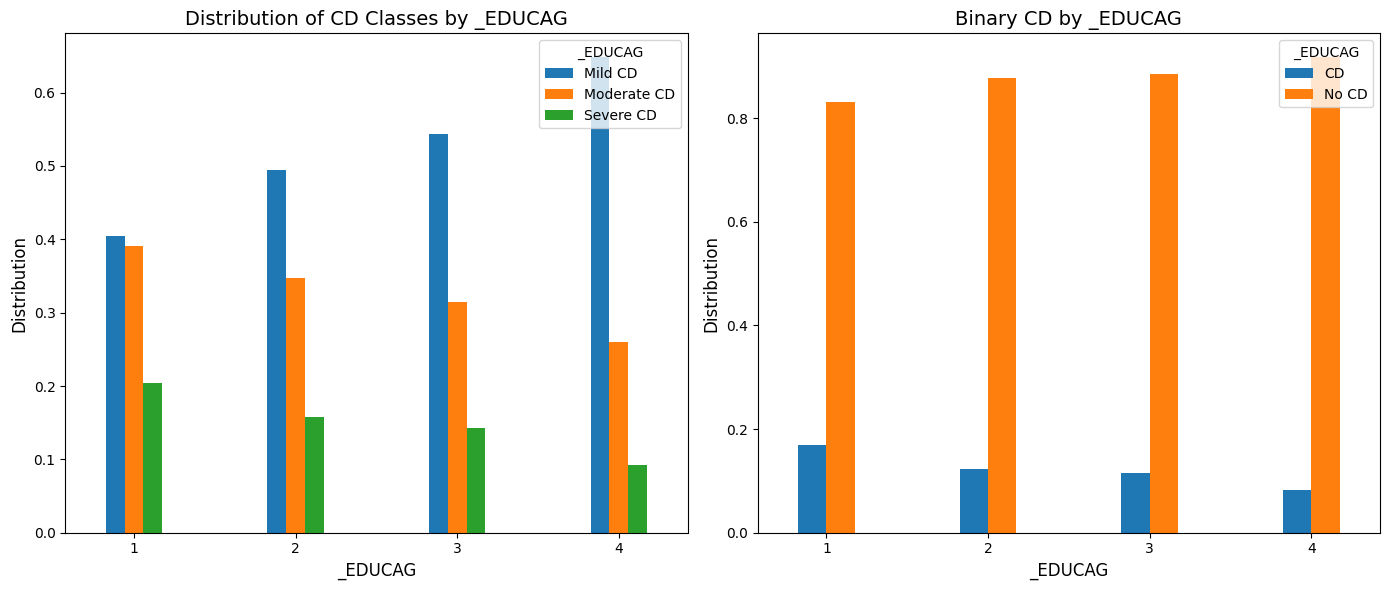

Cramers V for multi-class classification is: 0.1087493106153507
Cramers V for binary classification is: 0.07402471496056211


In [ ]:
mapping = {1: "1", 2: "2", 3: "3", 4: "4",6: "6", 9: "Refused"}
feature = '_EDUCAG'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 12531 refused values


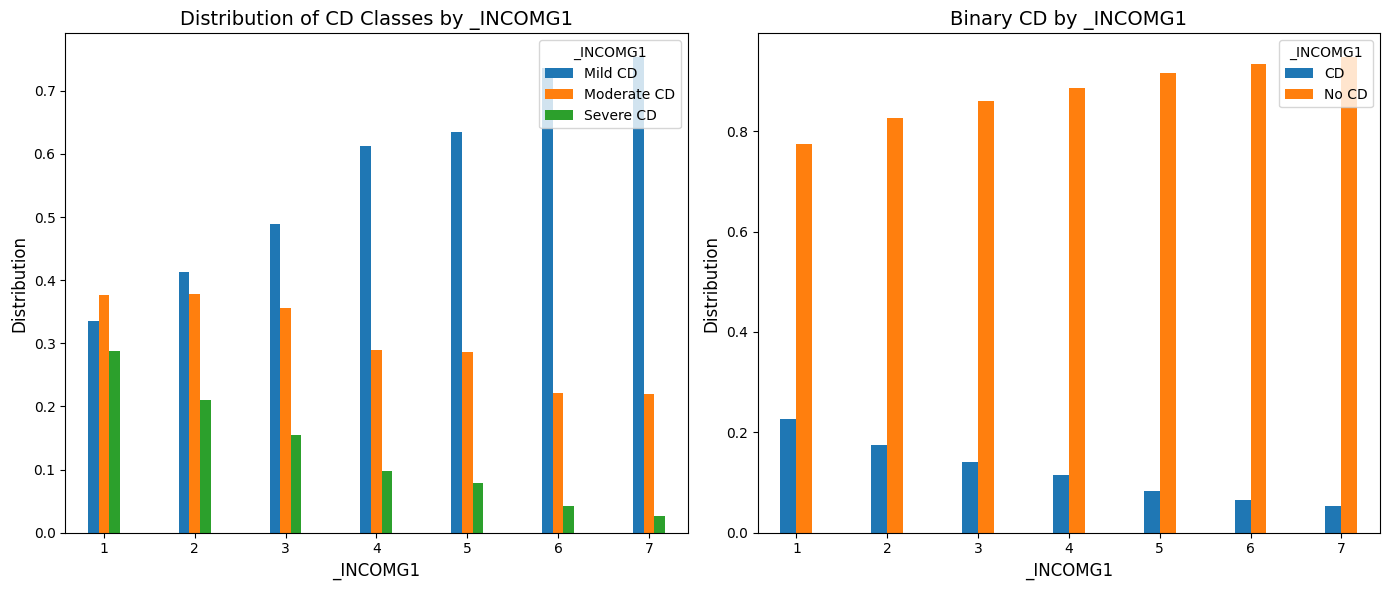

Cramers V for multi-class classification is: 0.2032489264187656
Cramers V for binary classification is: 0.14649975966855375


In [ ]:
mapping = {1: "1", 2: "2", 3: "3", 4: "4", 5:"5" ,6: "6", 7: "7",  8: "8", 9: "Refused"}
feature = '_INCOMG1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 29060 missing values, 0 not sure values, 689 refused values


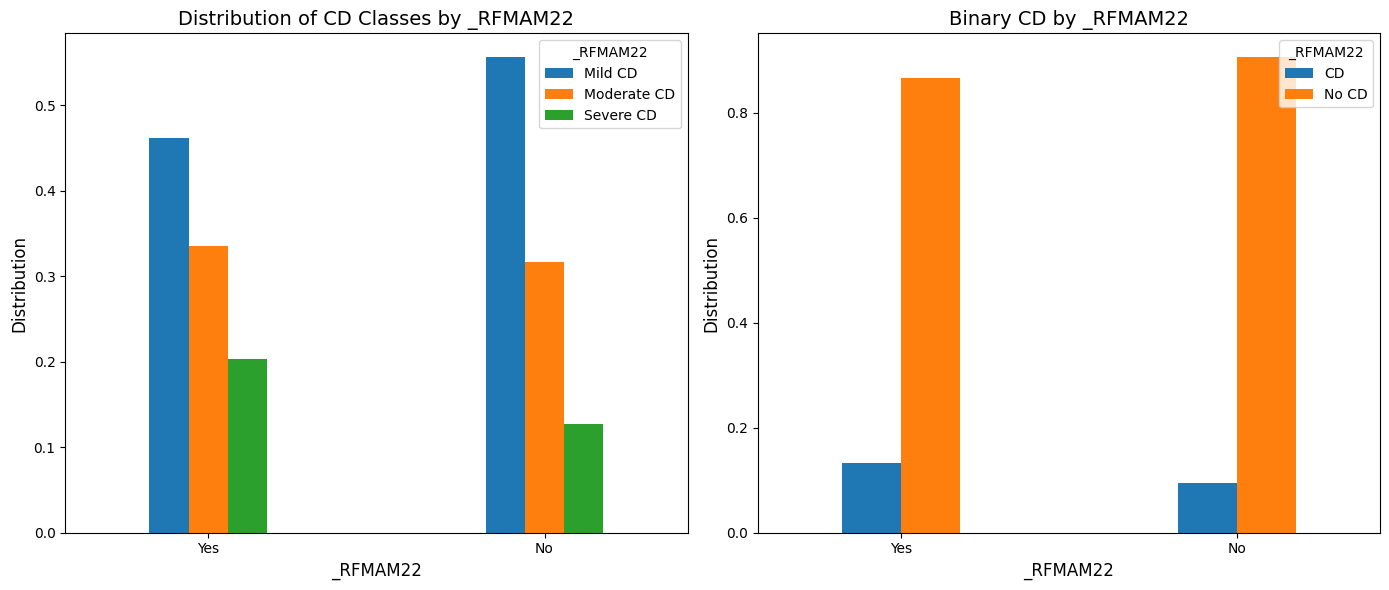

Cramers V for multi-class classification is: 0.10950577071801355
Cramers V for binary classification is: 0.05561108363979552


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_RFMAM22'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 40910 missing values, 0 not sure values, 0 refused values


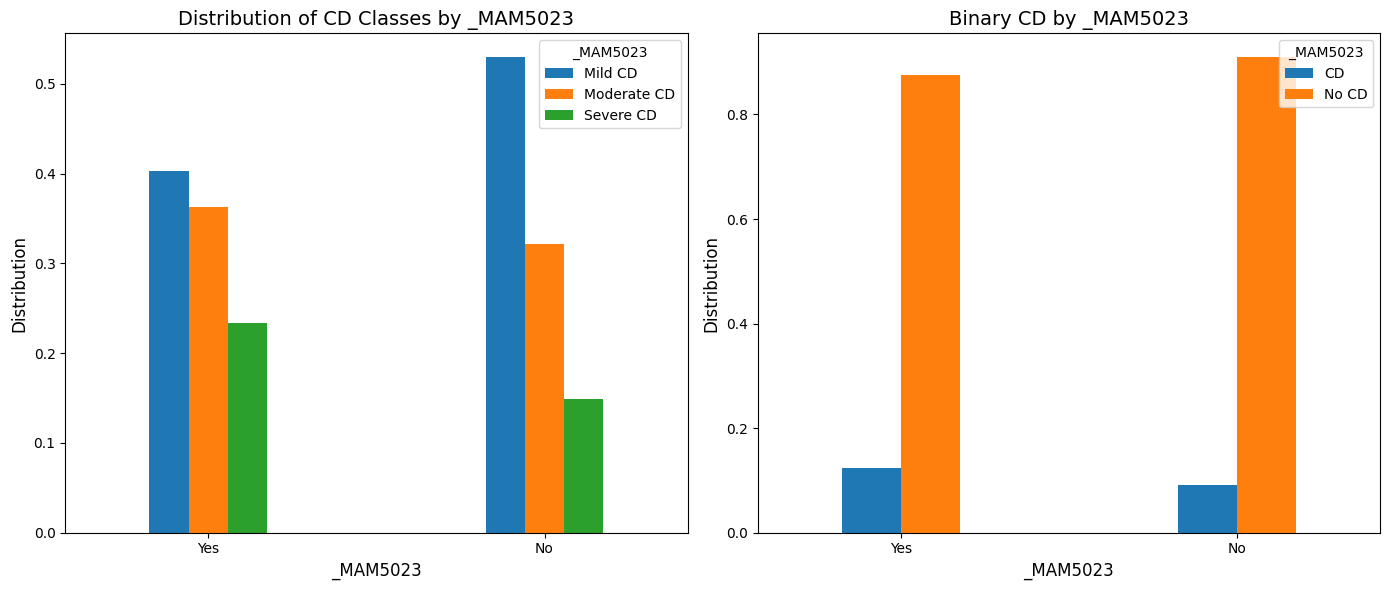

Cramers V for multi-class classification is: 0.12208947810760432
Cramers V for binary classification is: 0.04548775924751475


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_MAM5023'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 1235 missing values, 0 not sure values, 0 refused values


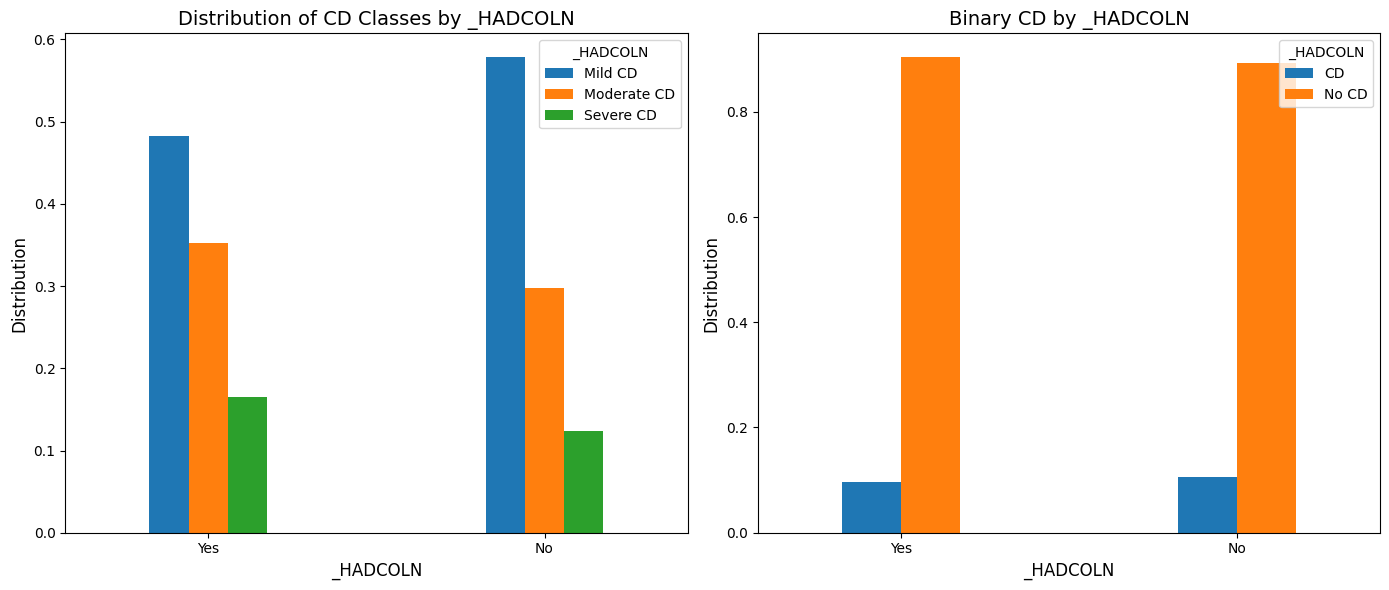

Cramers V for multi-class classification is: 0.0801319965157196
Cramers V for binary classification is: 0.014531762507406256


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_HADCOLN'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15487 missing values, 0 not sure values, 0 refused values


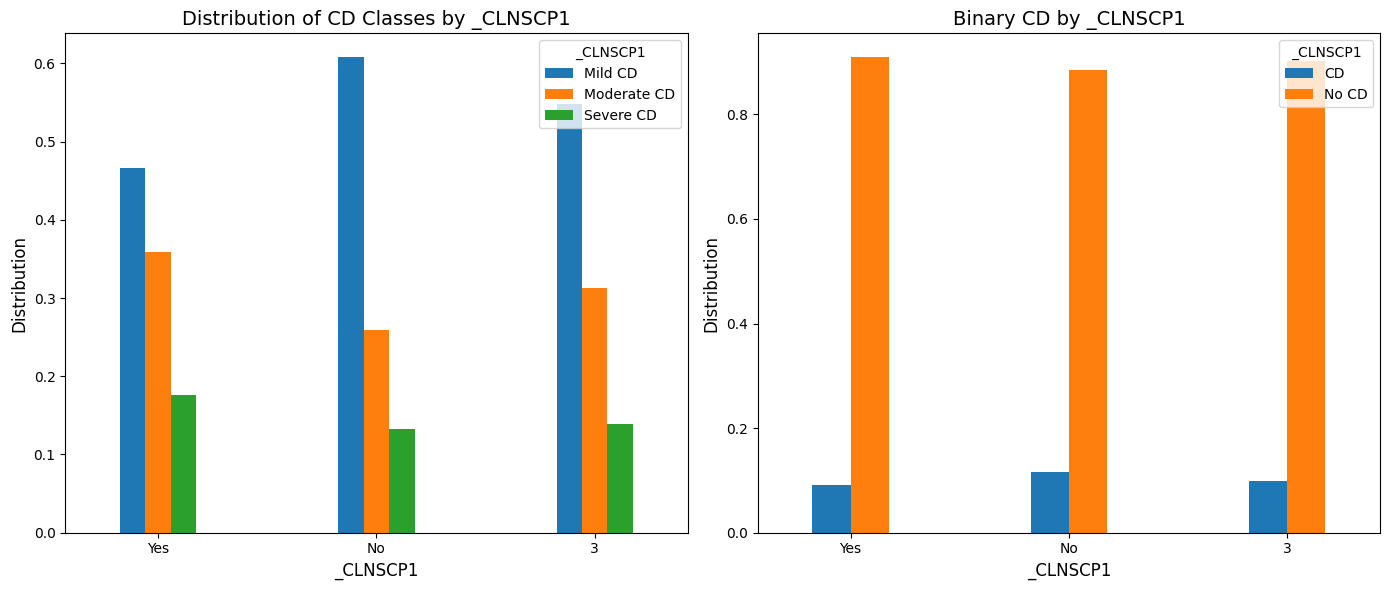

Cramers V for multi-class classification is: 0.05403361041287135
Cramers V for binary classification is: 0.0174479329776437


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_CLNSCP1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 1235 missing values, 0 not sure values, 0 refused values


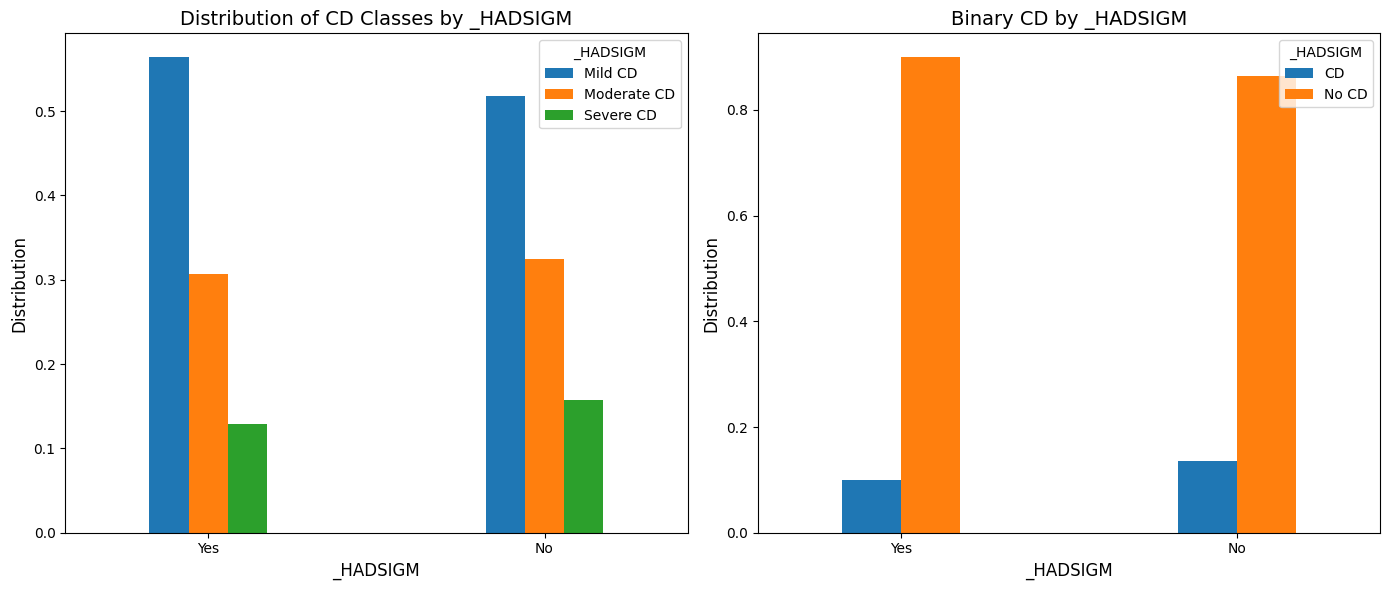

Cramers V for multi-class classification is: 0.033513803185443954
Cramers V for binary classification is: 0.037494395210817856


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_HADSIGM'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15495 missing values, 0 not sure values, 0 refused values


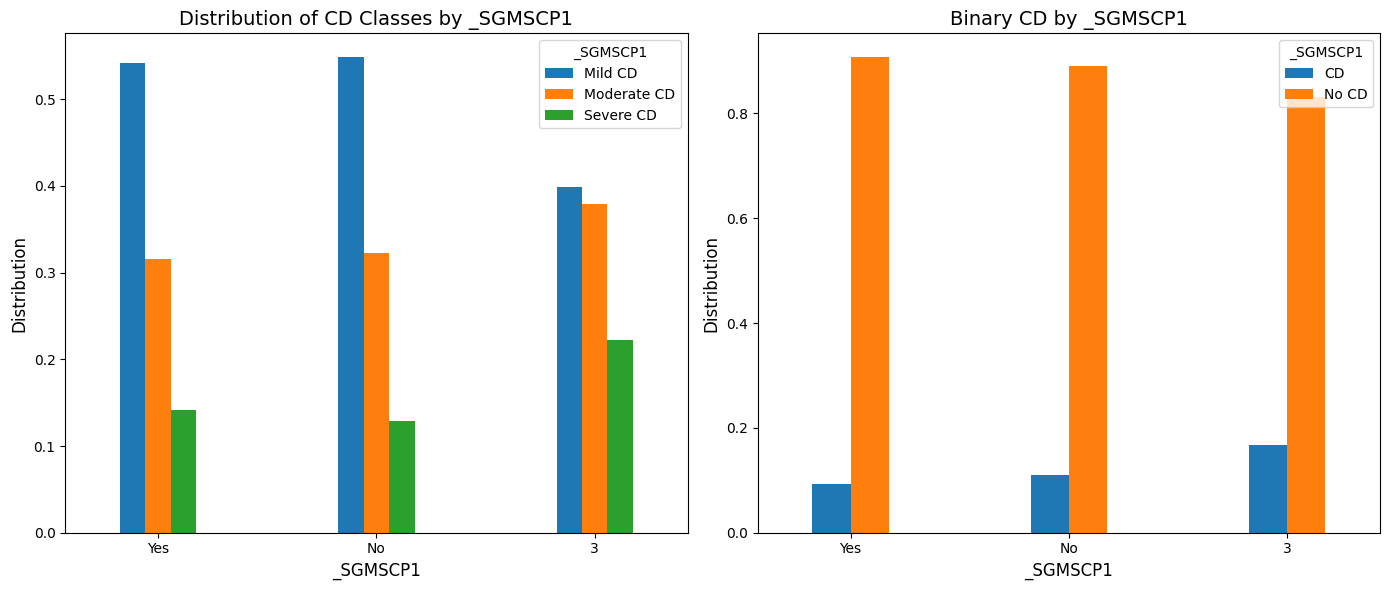

Cramers V for multi-class classification is: 0.05573191283443299
Cramers V for binary classification is: 0.05348768277518802


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_SGMSCP1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15495 missing values, 0 not sure values, 0 refused values


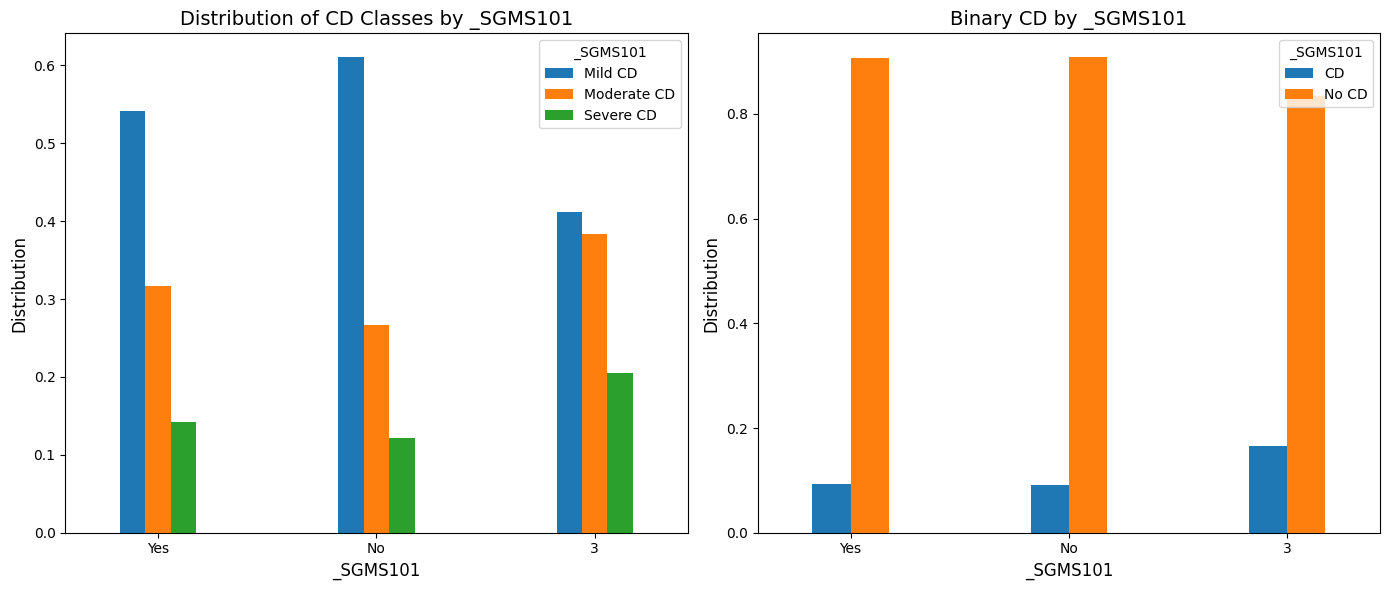

Cramers V for multi-class classification is: 0.056612164372312264
Cramers V for binary classification is: 0.05685689710076933


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_SGMS101'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15723 missing values, 0 not sure values, 0 refused values


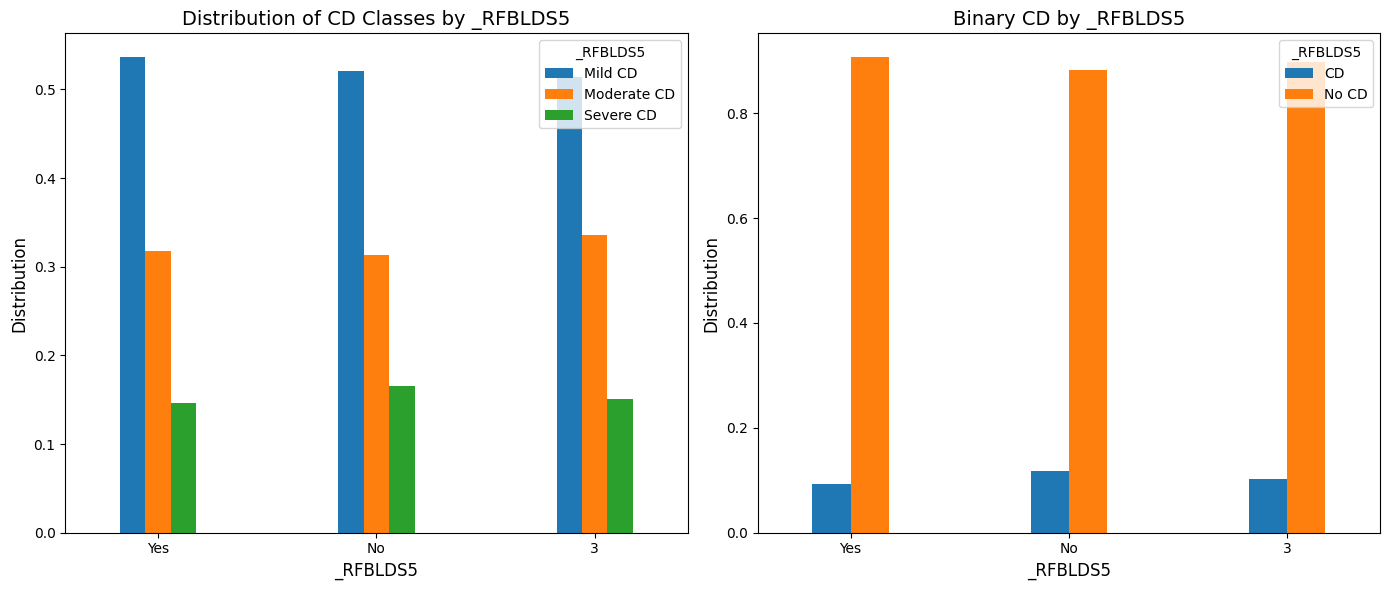

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.02370568869486042


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_RFBLDS5'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15770 missing values, 0 not sure values, 0 refused values


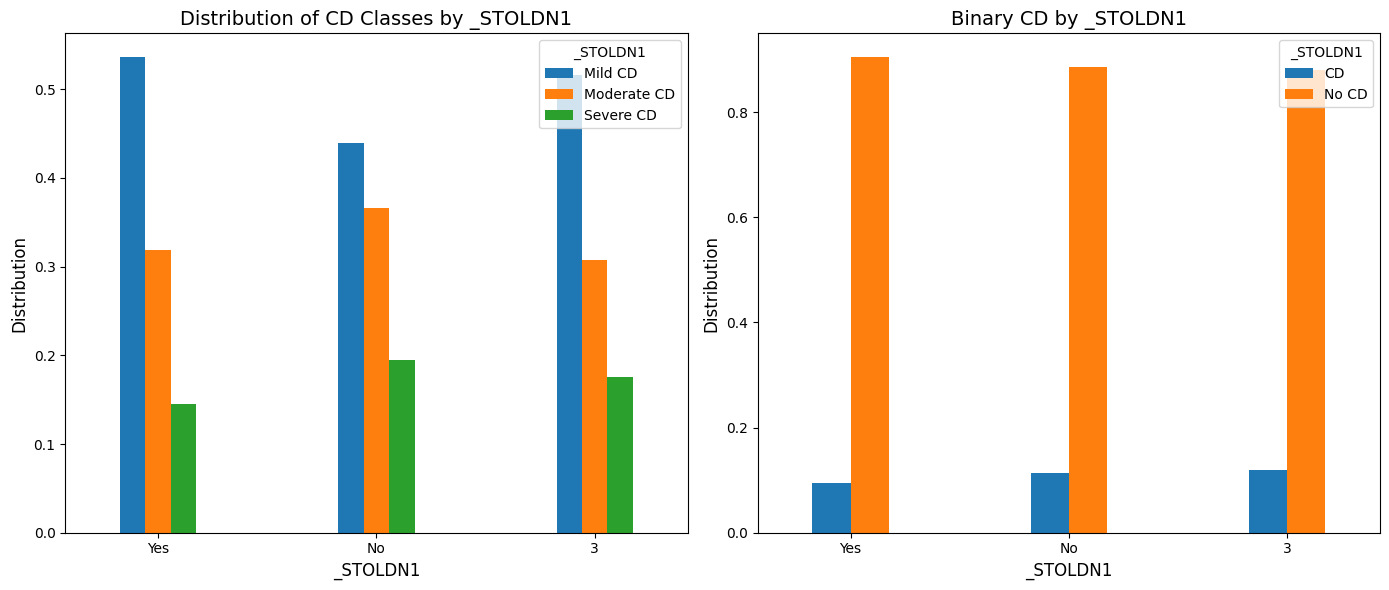

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.013640883206365799


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3",7: "Not Sure", 9: "Refused"}
feature = '_STOLDN1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15857 missing values, 0 not sure values, 0 refused values


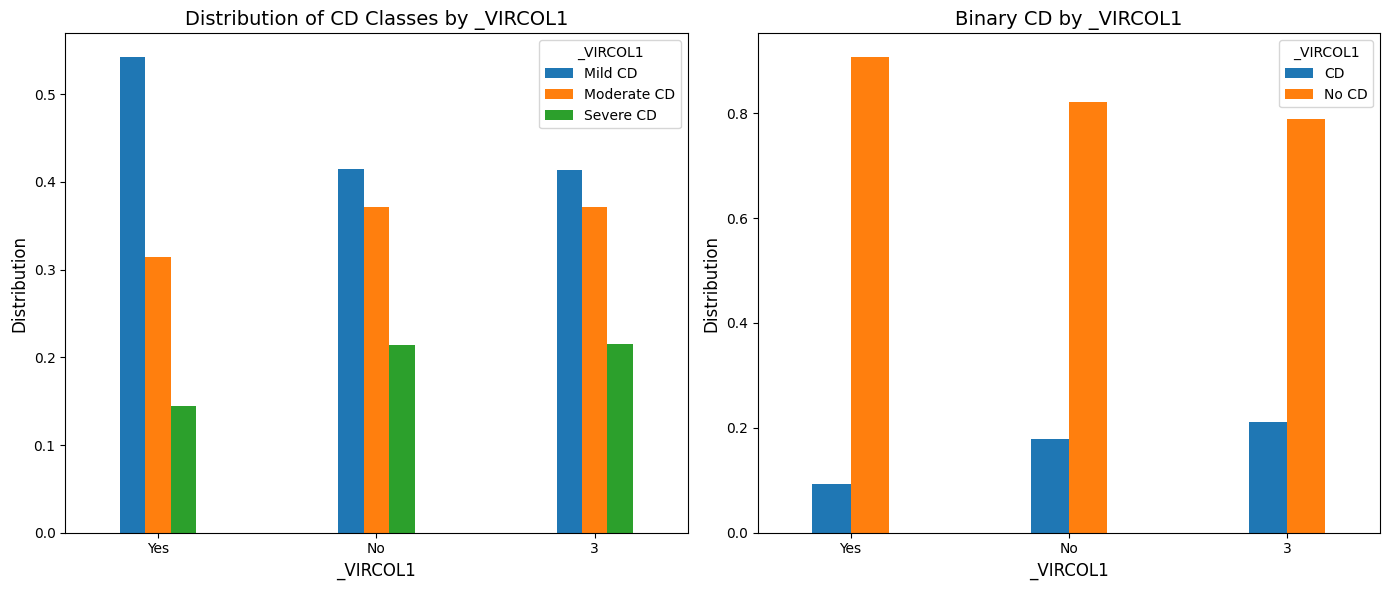

Cramers V for multi-class classification is: 0.03971046402192812
Cramers V for binary classification is: 0.059825503058541764


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_VIRCOL1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 16763 missing values, 0 not sure values, 0 refused values


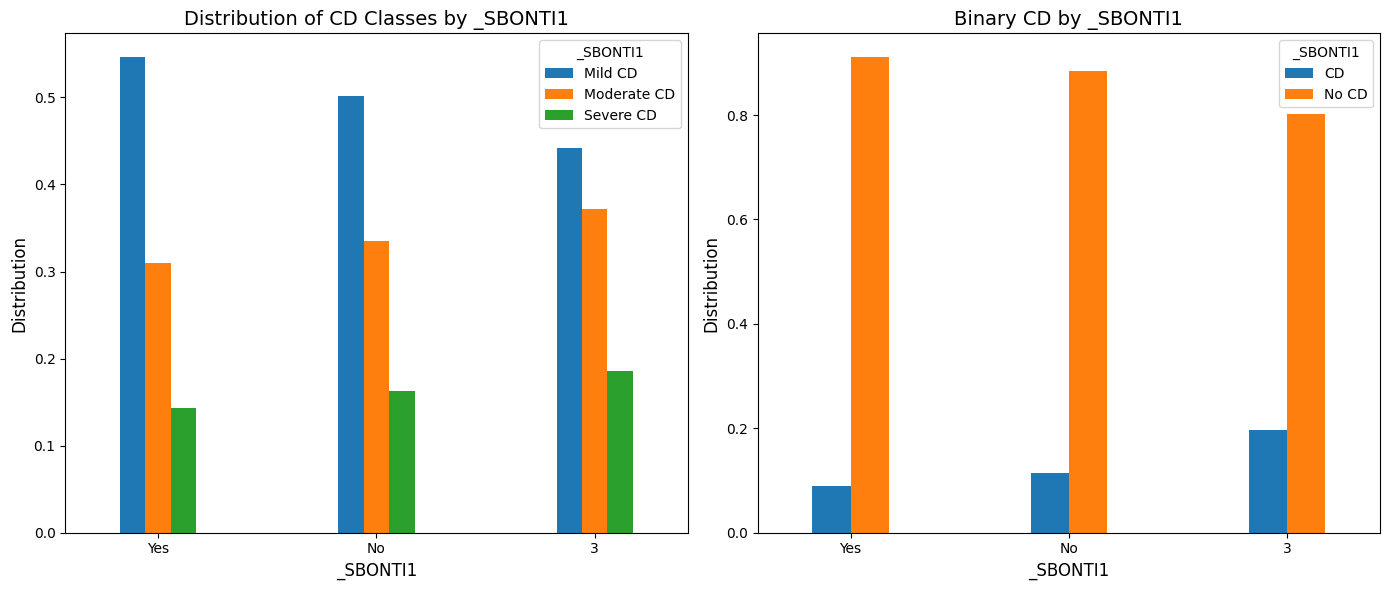

Cramers V for multi-class classification is: 0.022910677127402503
Cramers V for binary classification is: 0.04328097675362662


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_SBONTI1'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 15376 missing values, 0 not sure values, 0 refused values


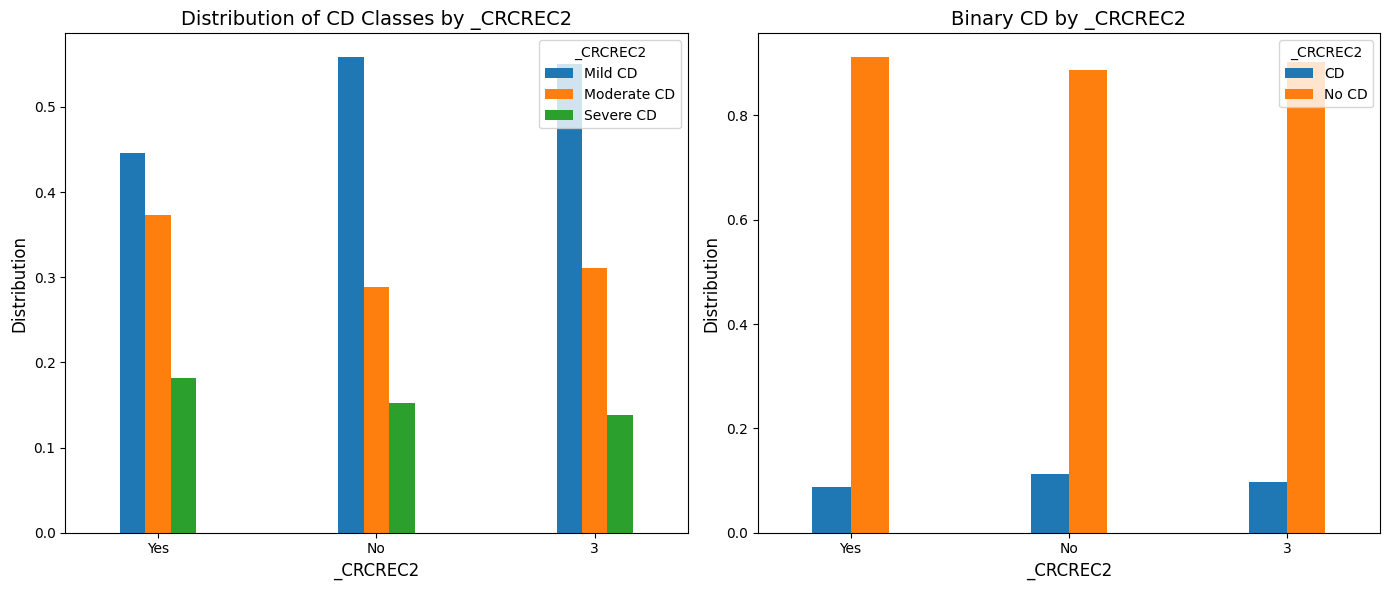

Cramers V for multi-class classification is: 0.05574001356517407
Cramers V for binary classification is: 0.018355420370947336


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 7: "Not Sure", 9: "Refused"}
feature = '_CRCREC2'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 536 refused values


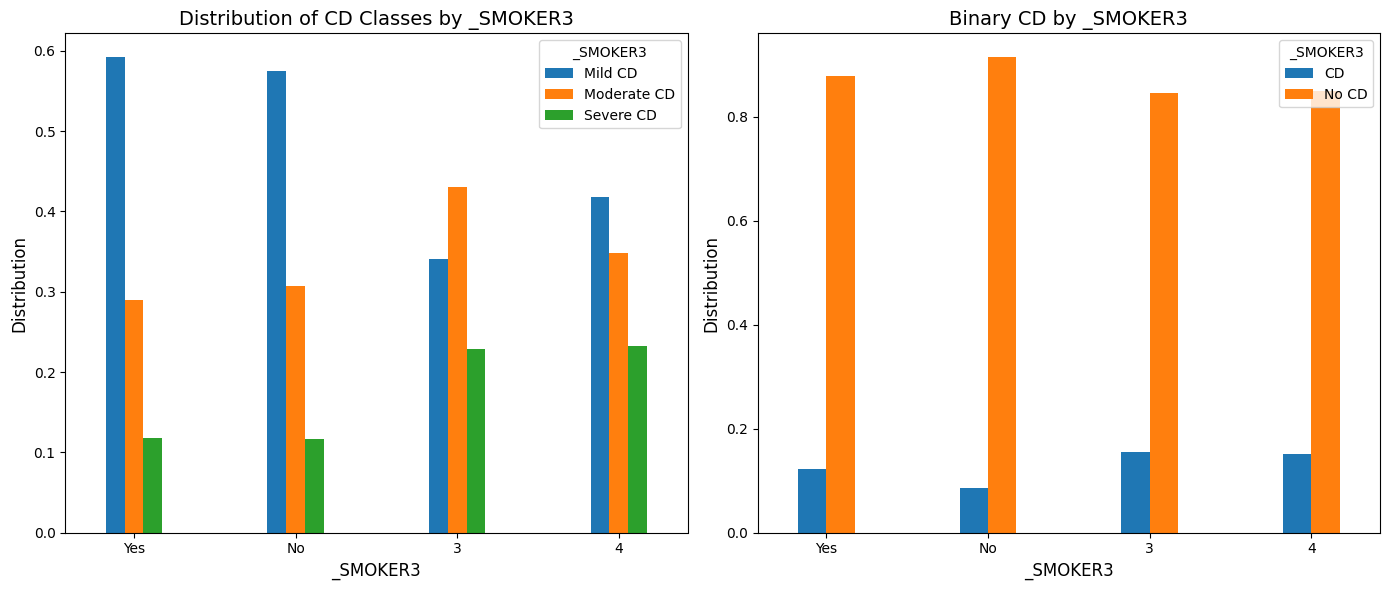

Cramers V for multi-class classification is: 0.10834385287232329
Cramers V for binary classification is: 0.0764378787980967


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 4: "4", 7: "Not Sure", 9: "Refused"}
feature = '_SMOKER3'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 536 refused values


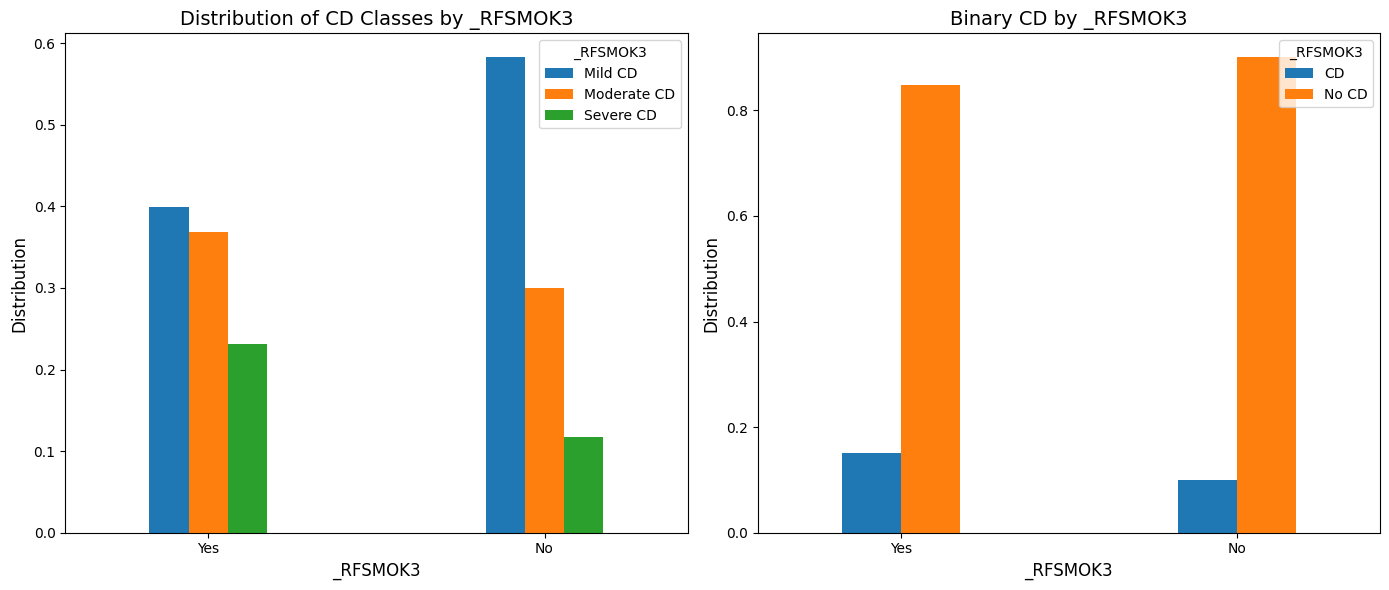

Cramers V for multi-class classification is: 0.15099184539718702
Cramers V for binary classification is: 0.053293254986778865


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_RFSMOK3'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 268 refused values


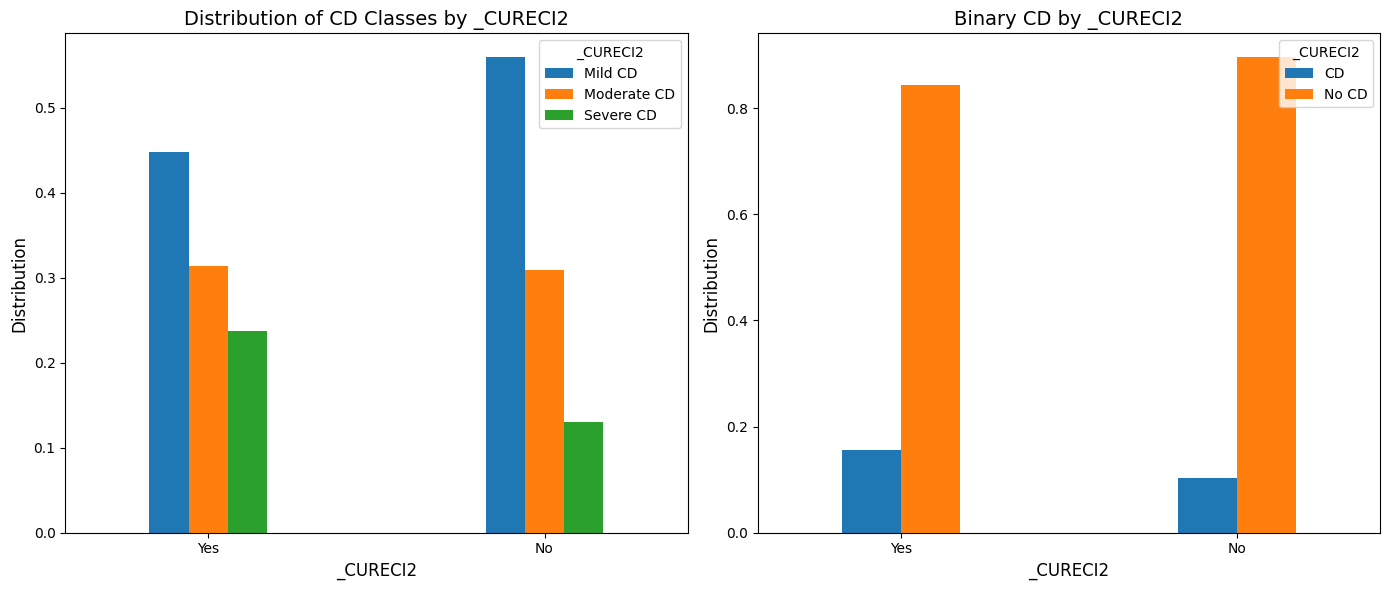

Cramers V for multi-class classification is: 0.05636542070118824
Cramers V for binary classification is: 0.024935239545922312


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_CURECI2'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 536 missing values, 0 not sure values, 0 refused values


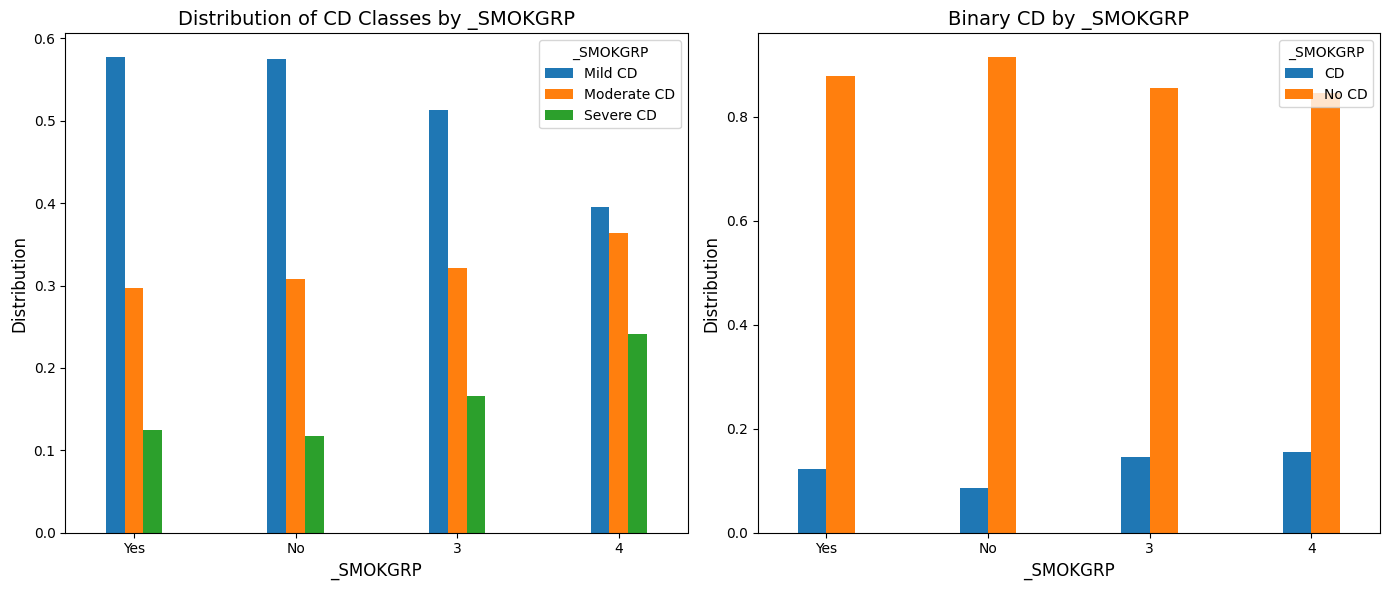

Cramers V for multi-class classification is: 0.08979848969262118
Cramers V for binary classification is: 0.07662330768203927


In [ ]:
mapping = {1: "Yes", 2: "No", 3: "3", 4: "4", 7: "Not Sure", 9: "Refused"}
feature = '_SMOKGRP'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 51899 missing values, 0 not sure values, 0 refused values


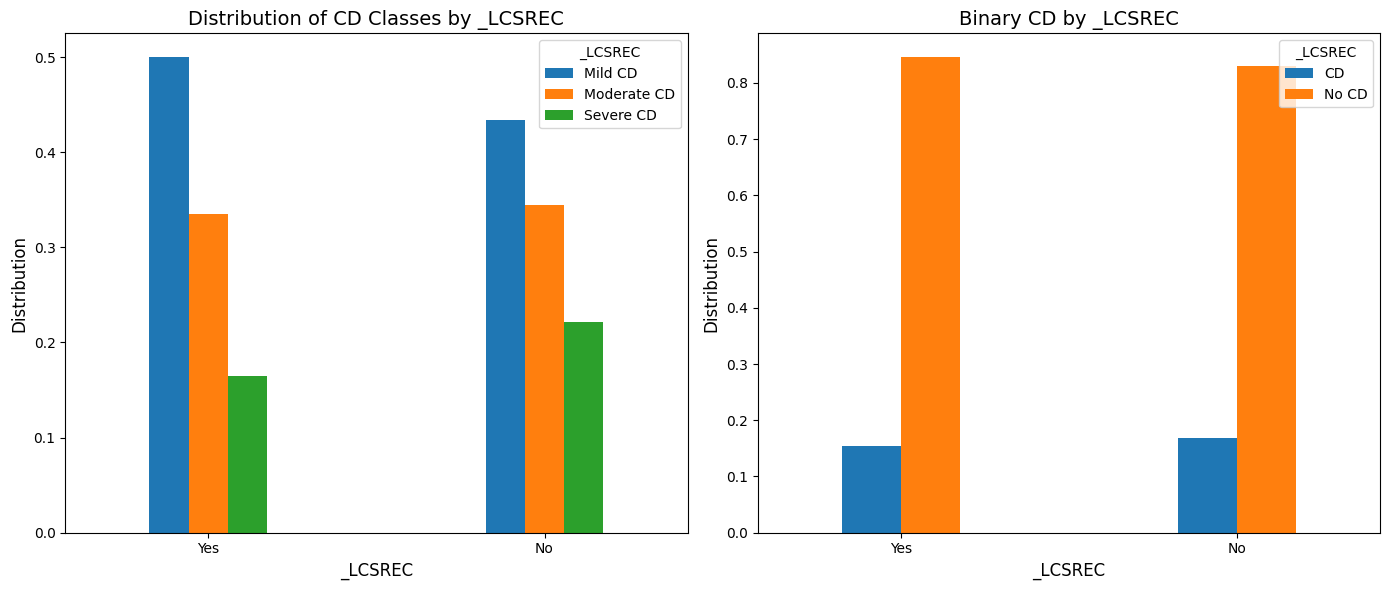

Cramers V for multi-class classification is: 0.04087765641617542
Cramers V for binary classification is: 0.007836593337636276


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_LCSREC'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 512 not sure values, 290 refused values


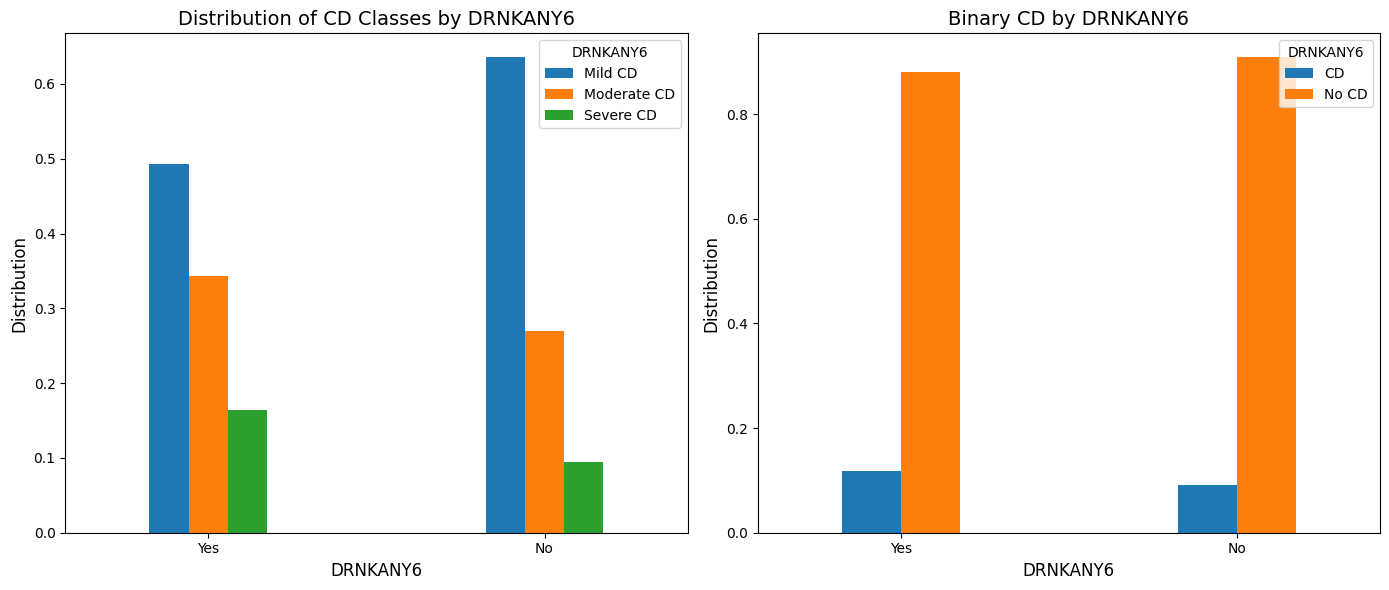

Cramers V for multi-class classification is: 0.14820035182034494
Cramers V for binary classification is: 0.04469849591451783


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = 'DRNKANY6'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 1279 refused values


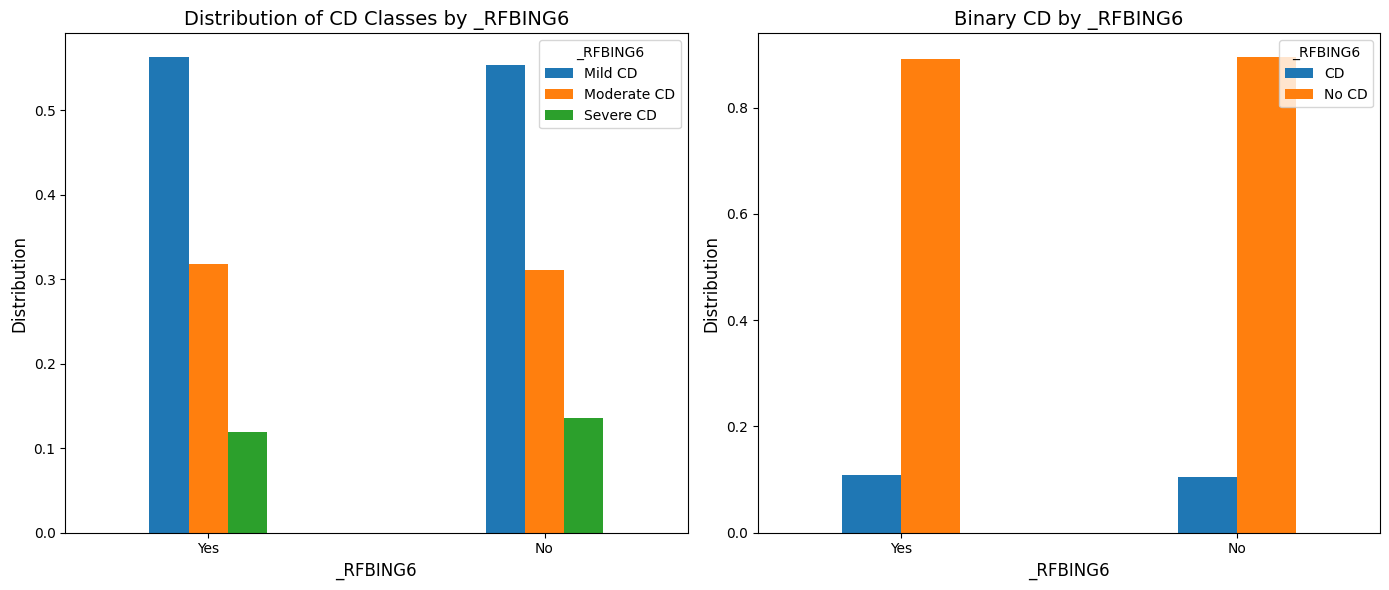

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.00044434125475082434


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_RFBING6'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 1125 refused values


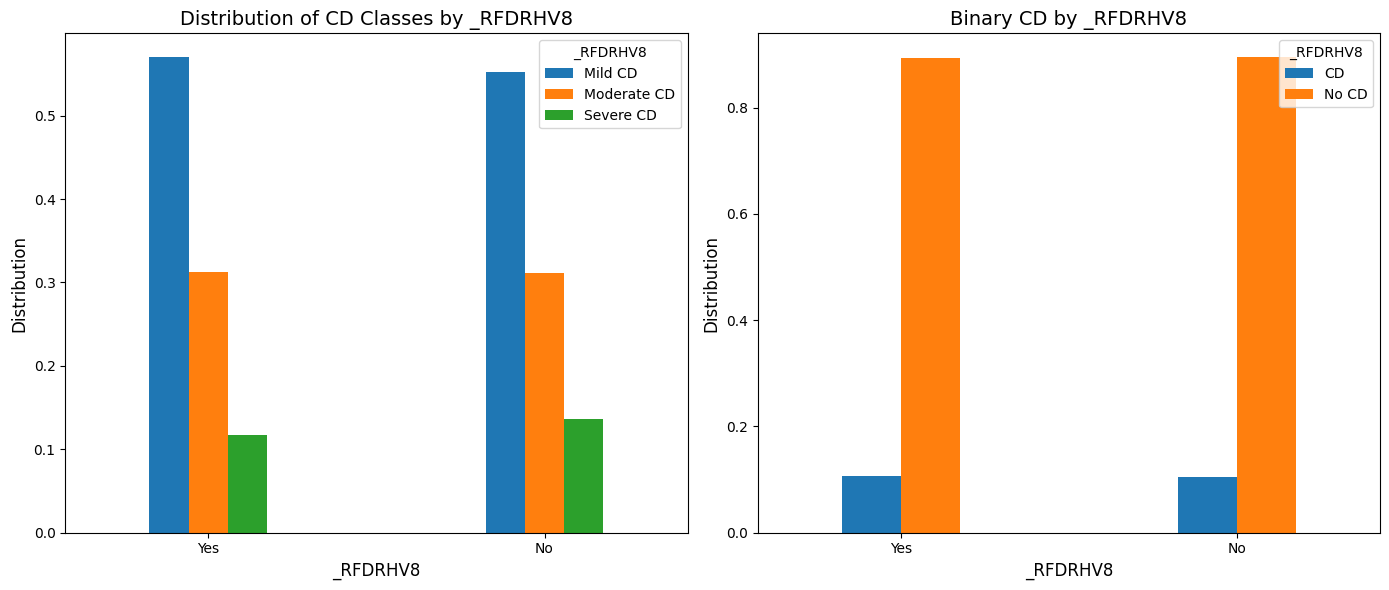

Cramers V for multi-class classification is: 0.0
Cramers V for binary classification is: 0.0


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_RFDRHV8'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 28193 missing values, 0 not sure values, 1431 refused values


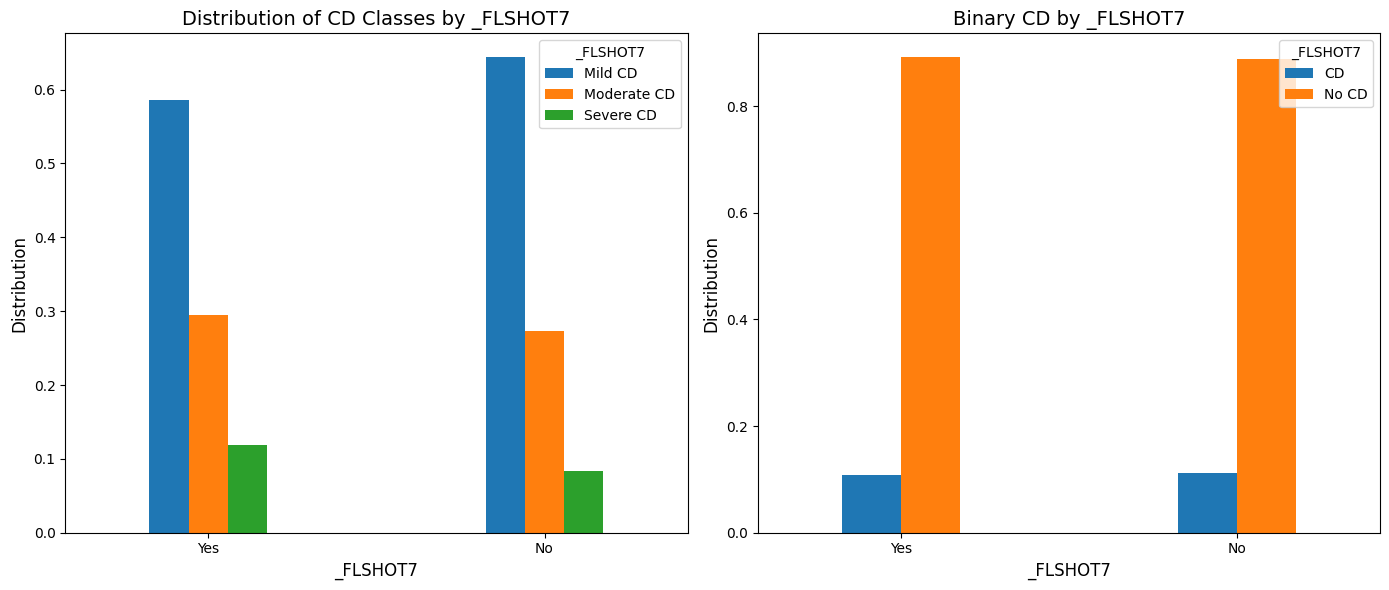

Cramers V for multi-class classification is: 0.06154046707535192
Cramers V for binary classification is: 0.003186835307531714


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_FLSHOT7'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 28193 missing values, 0 not sure values, 2350 refused values


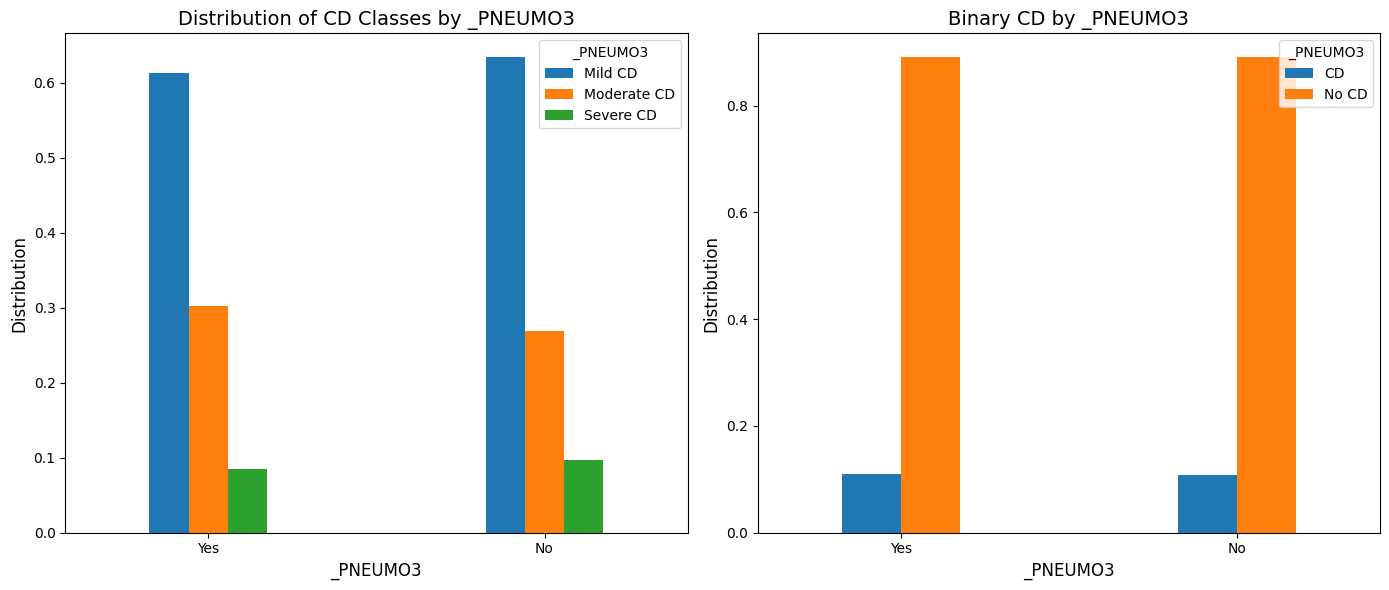

Cramers V for multi-class classification is: 0.025641976959463936
Cramers V for binary classification is: 0.0


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_PNEUMO3'

explore_cat(df, feature, mapping, include_refused=False)

<ipython-input-21-d0a7d89988d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf[feature] = subdf[feature].replace(mapping)
<ipython-input-21-d0a7d89988d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset = [feature], inplace=True)
<ipython-input-21-d0a7d89988d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

There are 0 missing values, 0 not sure values, 3577 refused values


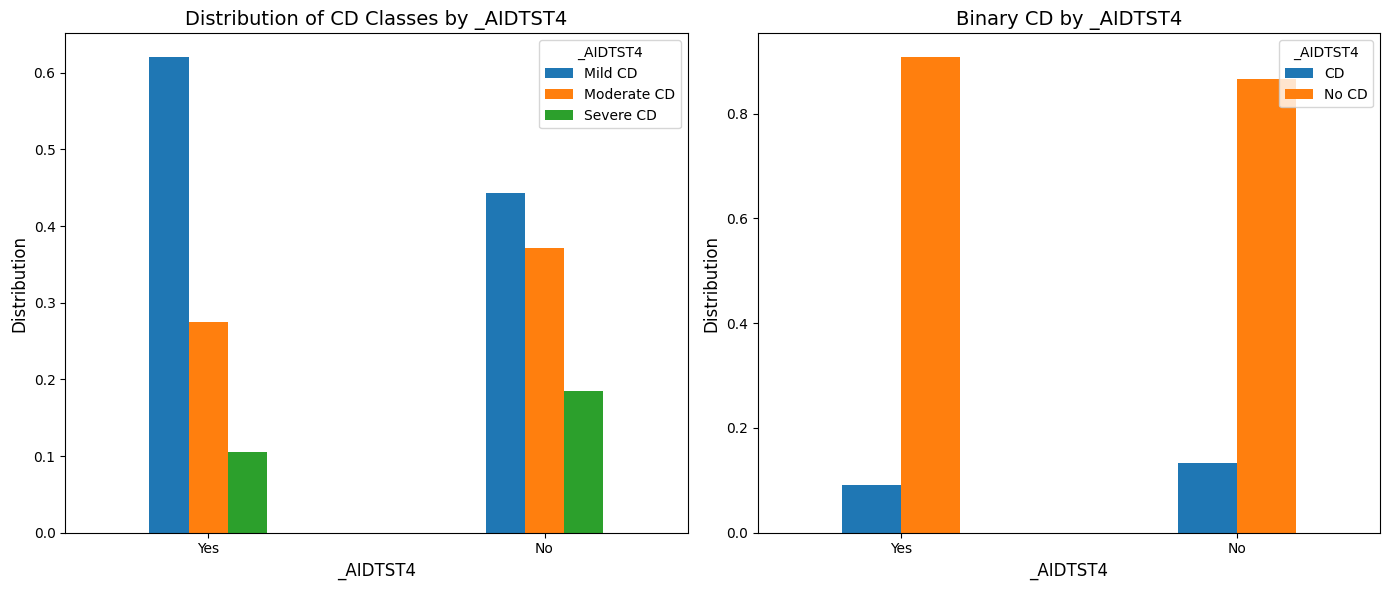

Cramers V for multi-class classification is: 0.1752168665126862
Cramers V for binary classification is: 0.06151272851742452


In [ ]:
mapping = {1: "Yes", 2: "No", 7: "Not Sure", 9: "Refused"}
feature = '_AIDTST4'

explore_cat(df, feature, mapping, include_refused=False)

## Continuous

In [ ]:
#@title Function for continuous variable exploration
def explore_cts(df, feature, none=88, not_sure=77, refused=99):
  subdf = df[[feature, 'Class']]
  print(f'There are {subdf[feature].isna().sum()} missing values, {np.sum(subdf[feature]==not_sure)} not sure values, {np.sum(subdf[feature]==refused)} refused values')

  if np.sum(~subdf[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset=[feature], inplace=True)
    subdf = subdf[~((subdf[feature]==not_sure) | (subdf[feature]==refused))]
    subdf[feature] = subdf[feature].replace(none, 0)

    desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
    desired_order2 = ['CD', 'No CD']

    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    sns.kdeplot(data=subdf[(subdf['Class']!='No CD')], x=feature, hue='Class', hue_order=desired_order,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(f'Distribution of {feature} within different CD classes', fontsize=14)
    axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')

    sns.kdeplot(data=subdf, x=feature, hue='Binary Classification', hue_order=desired_order2,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Distribution of {feature} with and without CD', fontsize=14)
    axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')

    plt.tight_layout()
    plt.show()

    groups = [group[feature] for name, group in subdf[(subdf['Class']!='No CD')].groupby('Class')]
    f_statistic, p_value = f_oneway(*groups)

    print("p-value for multi-class classification is:", p_value)

    groups2 = [group[feature] for name, group in subdf.groupby('Binary Classification')]
    f_statistic, p_value2 = f_oneway(*groups2)

    print("p-value for binary classification:", p_value2)

## Test

There are 0 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


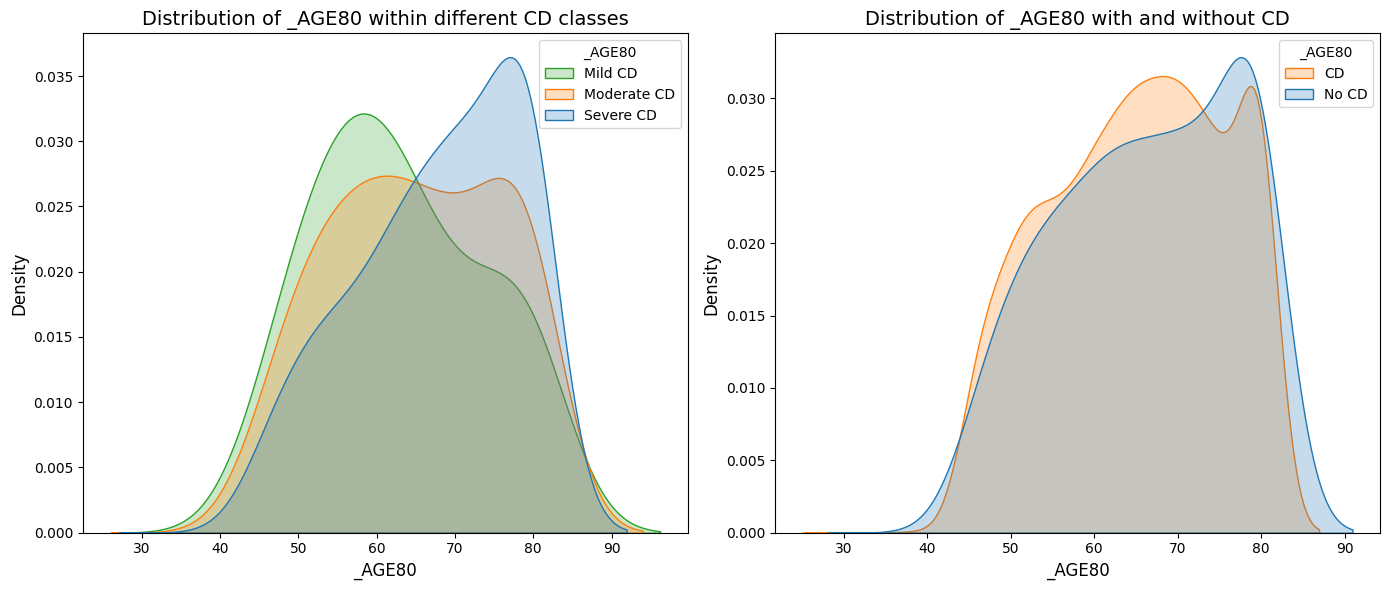

p-value for multi-class classification is: 3.433693510197567e-43
p-value for binary classification: 2.698457244386335e-19


In [ ]:
feature = '_AGE80'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 1549 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


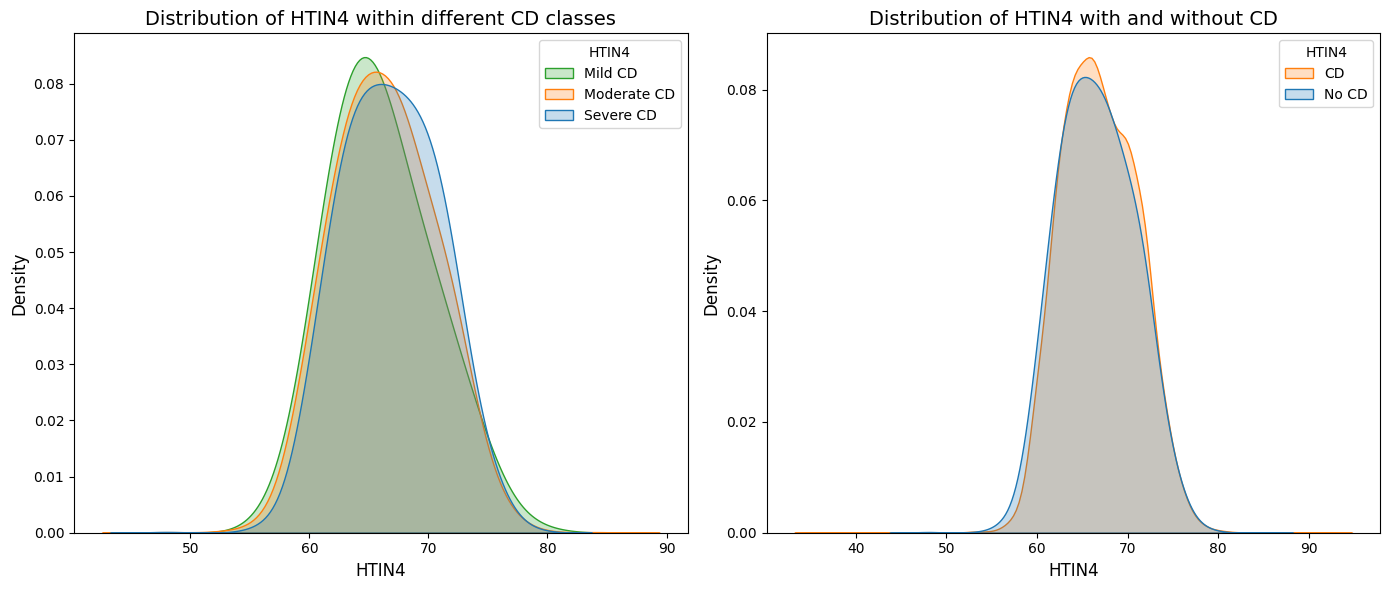

p-value for multi-class classification is: 1.723477168381713e-08
p-value for binary classification: 3.289621352343195e-09


In [ ]:
feature = 'HTIN4'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 1345 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


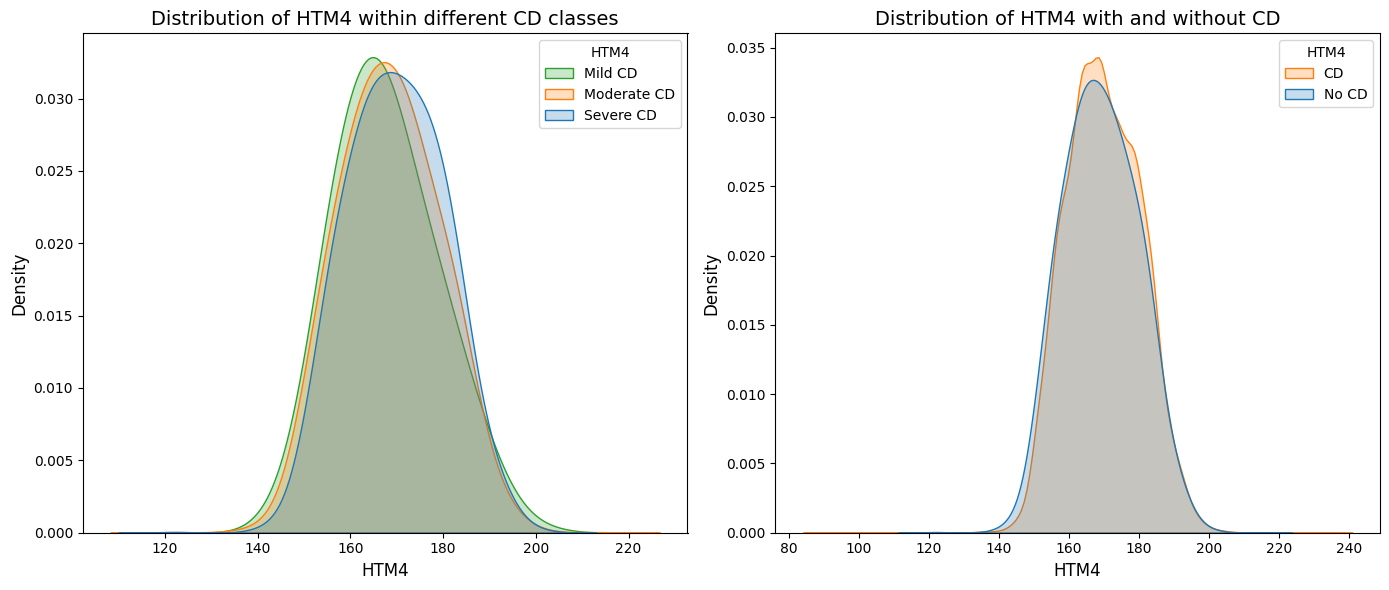

p-value for multi-class classification is: 5.0998435819344994e-09
p-value for binary classification: 3.122526092370974e-09


In [ ]:
feature = 'HTM4'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 4149 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


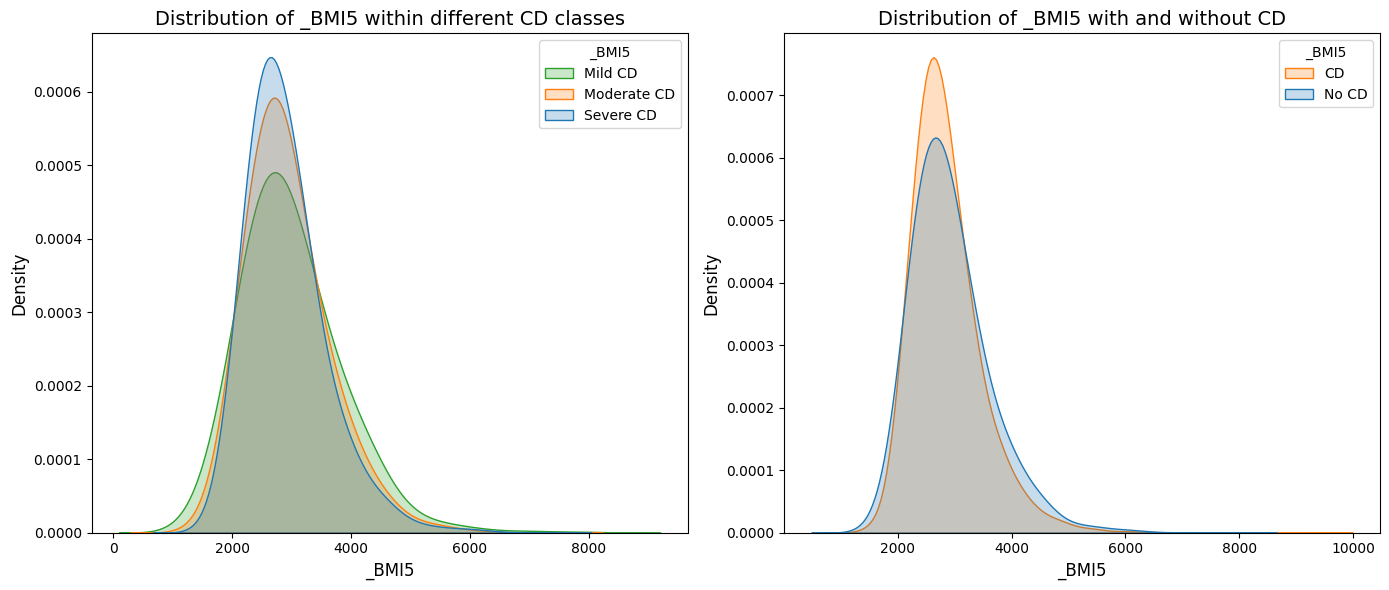

p-value for multi-class classification is: 0.002777976578445415
p-value for binary classification: 1.0602125222459791e-16


In [ ]:
feature = '_BMI5'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 38608 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


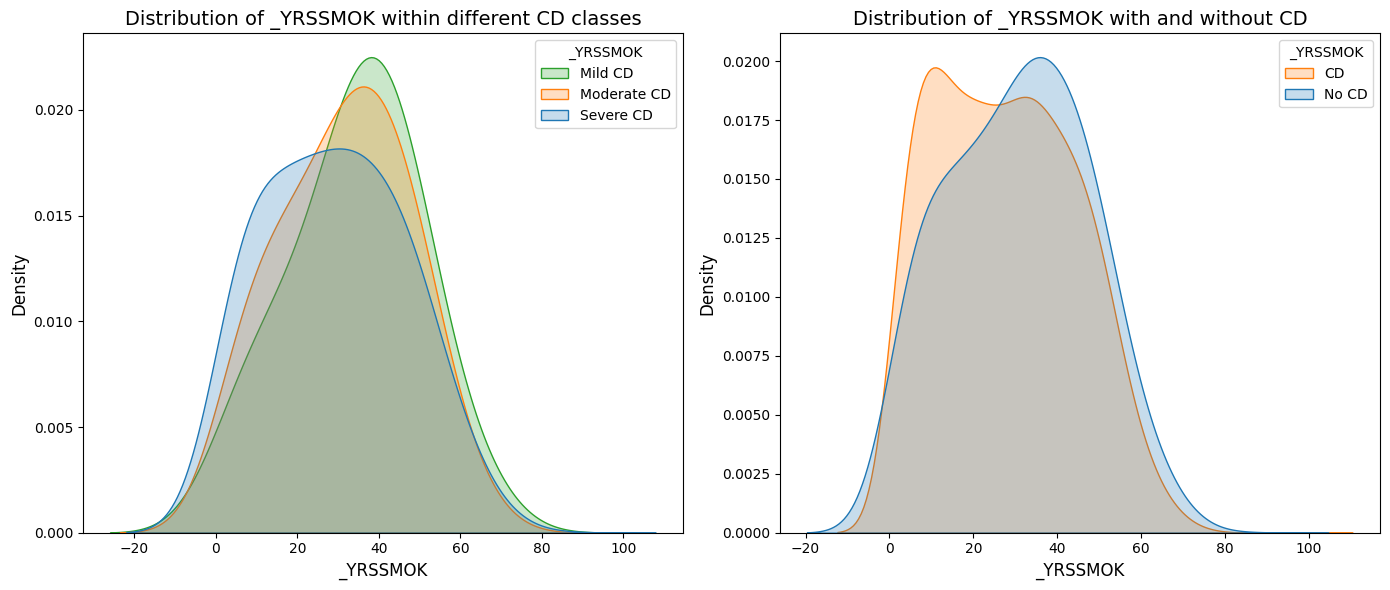

p-value for multi-class classification is: 5.595115949677958e-10
p-value for binary classification: 4.278528395058719e-22


In [ ]:
feature = '_YRSSMOK'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 37763 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


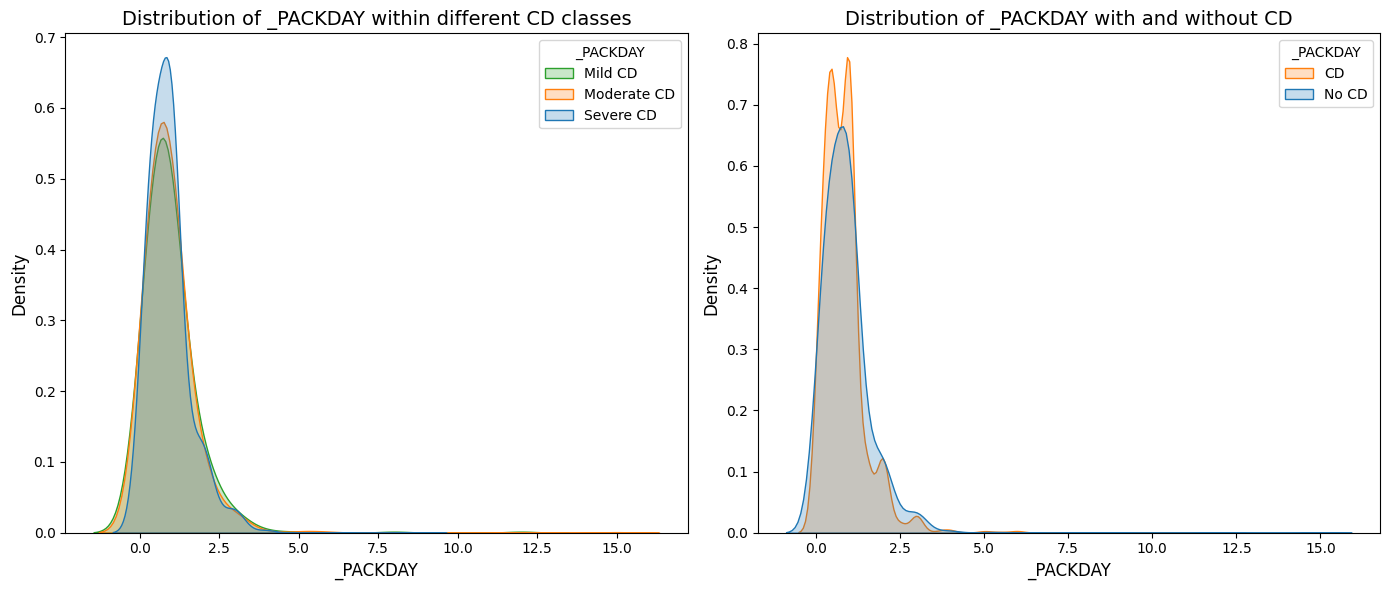

p-value for multi-class classification is: 0.492742661536113
p-value for binary classification: 3.500531292866126e-10


In [ ]:
feature = '_PACKDAY'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 39416 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


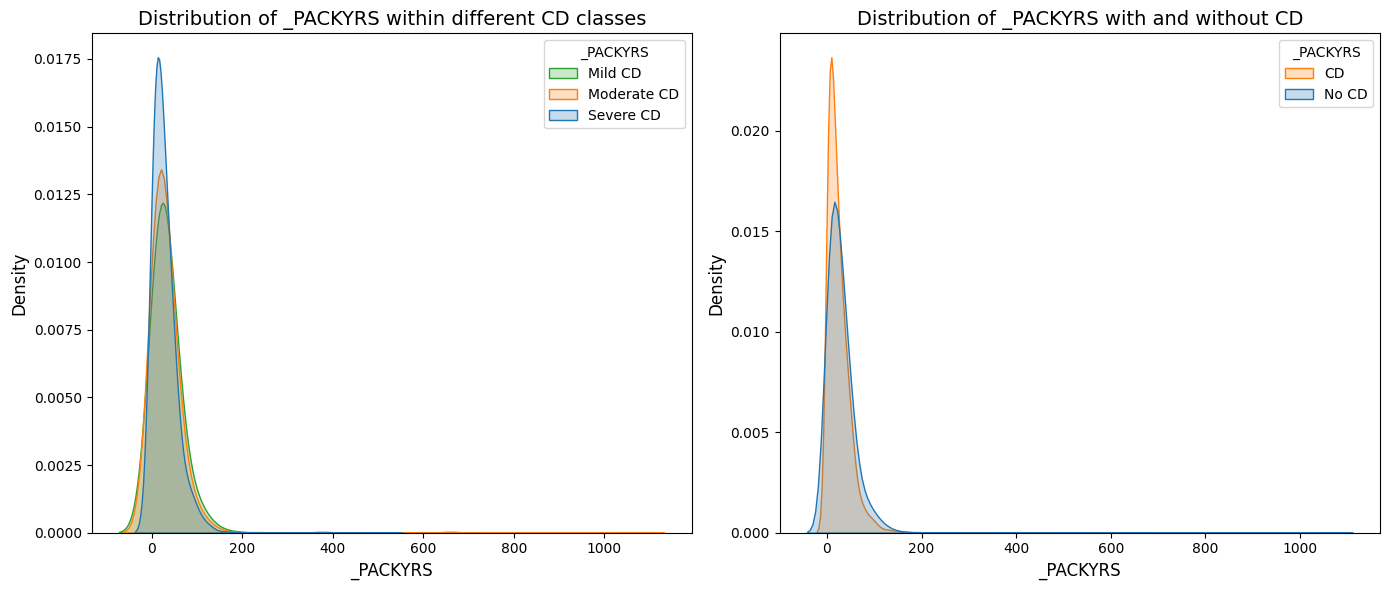

p-value for multi-class classification is: 0.0013609741647729373
p-value for binary classification: 7.186351554473903e-19


In [ ]:
feature = '_PACKYRS'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 44414 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


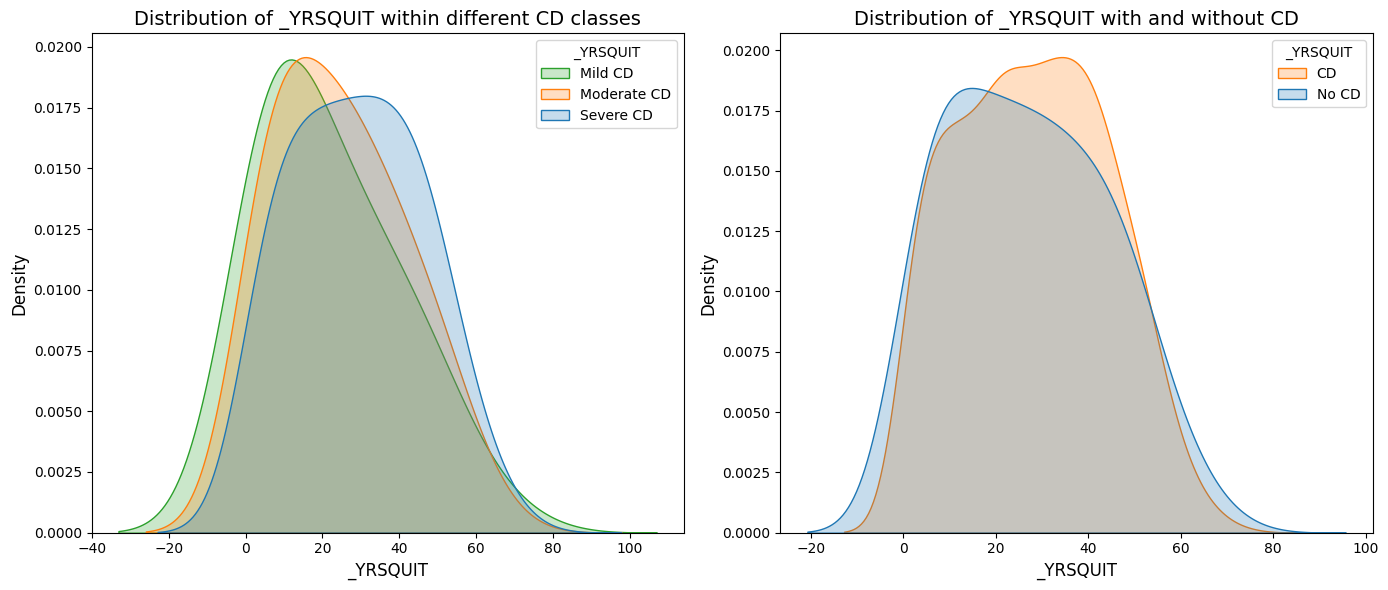

p-value for multi-class classification is: 1.8414061842623017e-13
p-value for binary classification: 0.0018622569408837109


In [ ]:
feature = '_YRSQUIT'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 0 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


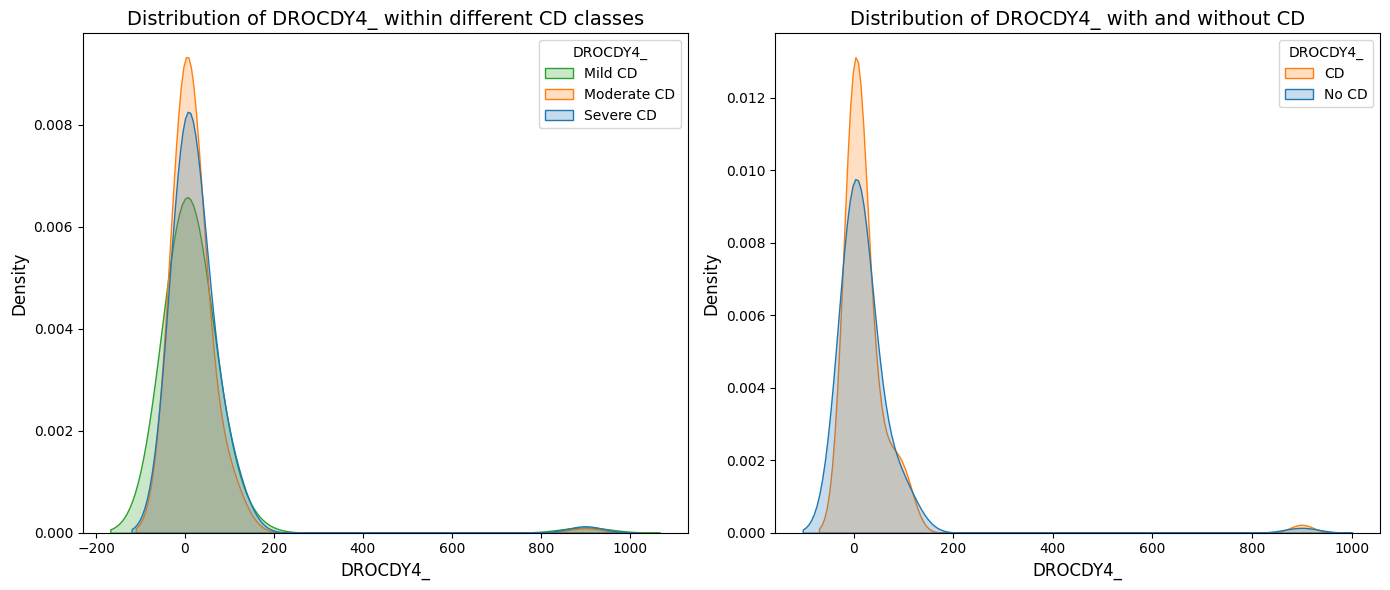

p-value for multi-class classification is: 0.0022795338064739443
p-value for binary classification: 0.011205092806406077


In [ ]:
feature = 'DROCDY4_'

explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 0 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


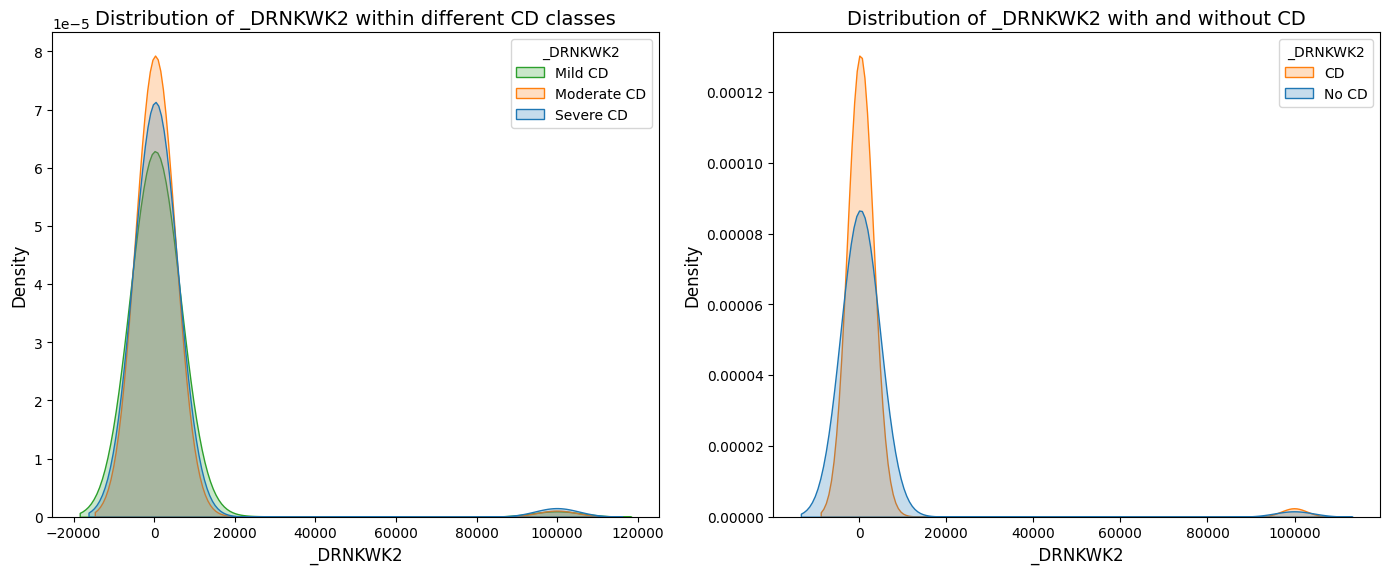

p-value for multi-class classification is: 0.08534408618653028
p-value for binary classification: 0.8390135586320286


In [ ]:
feature = '_DRNKWK2'
explore_cts(df, feature, none=88, not_sure=998, refused=999)

There are 3759 missing values, 0 not sure values, 0 refused values


<ipython-input-115-4821ad4ff3ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.dropna(subset=[feature], inplace=True)


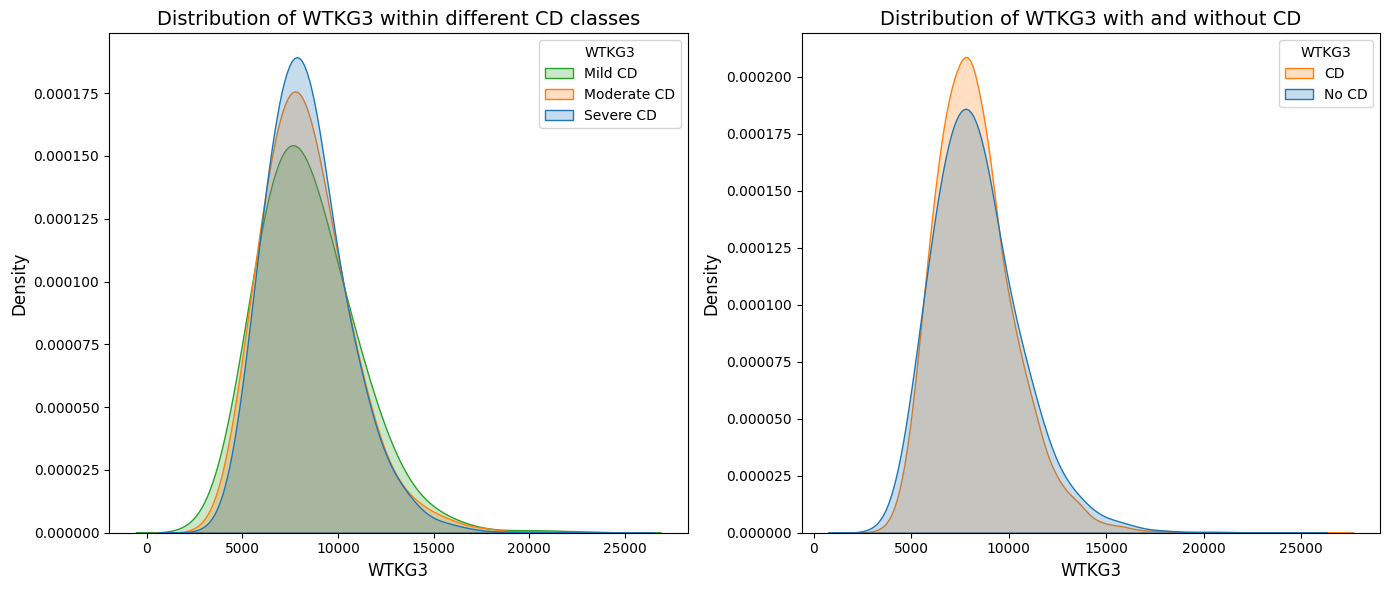

p-value for multi-class classification is: 0.5789942809006086
p-value for binary classification: 4.9562125251832e-05


In [ ]:
feature = 'WTKG3'

explore_cts(df, feature, none=88, not_sure=998, refused=999)